In [55]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers


In [57]:
train = pd.read_csv('train.csv')
train.shape
train = train.loc[np.random.choice(train.index, size=100000)]

In [58]:
train=train[~train.index.duplicated()]
train['bad_comment']=0

train['bad_comment']= train.iloc[:,2:].sum(axis=1)


train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,bad_comment
146446,2c573d607b91a382,"""\n\nOld username\nJust wondering, your old us...",0,0,0,0,0,0,0
8559,16b8f52f2b91cc1f,"Don't threaten me, I don't respond kindly to ...",1,0,0,0,0,0,1
144631,1002a0378862ff00,I removed the link to the Nouvelle Droite. Ed...,0,0,0,0,0,0,0
150413,6bdc04ced28d94fe,"""\n\n Please stop posting about this on my use...",0,0,0,0,0,0,0
131362,becc6c51cb7f69c1,A note from a legitimate user of this IP: This...,0,0,0,0,0,0,0


In [59]:
df=train
df['bad_comment'].values[df['bad_comment'].values >= 1] = 1

In [60]:
from sklearn.utils import resample
data_raw3=df


df_majority = df[df.bad_comment==0]
df_minority = df[df.bad_comment>=1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=8000,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.bad_comment.value_counts()

df_downsampled.shape


(15586, 9)

In [61]:
data2=df_downsampled
missing_values_check = data2.isnull().sum()
print(missing_values_check)
data2.drop(['bad_comment'],axis=1)

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
bad_comment      0
dtype: int64


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
70951,bde24a2937f41f94,Obvious that I consider my block unfair.\nBut ...,0,0,0,0,0,0
113055,5c9f3eb1bc92e822,"""\n\n Mesut Ozil had a Turkish passport until ...",0,0,0,0,0,0
84023,e0d90d07f8346a7a,"""\n\nI will not tolerate this racism from all ...",0,0,0,0,0,0
31538,53bd5da134b393be,. It's a variant of what's called “saturation”...,0,0,0,0,0,0
44663,775a25e2a424cab6,"""\n\nVague and Unsourced\n\nThis statement, ne...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
116644,6f91db77d5fbb3c3,"Hi will, are you a nigger by any chance? I am ...",0,0,0,0,1,1
2575,06e2bb0770387ff3,"Why, the stupid blocked? \n\nBut, I'm sorry, b...",1,0,0,0,0,0
55304,93bc8a50b2a80527,"Elsewhere I am nothing but sunshine, gumdrops ...",0,0,1,0,1,0
122370,8e8fcbb31e21e24a,' Bold text \n'BRIDGER IS THE MOTHER FUCKING S...,1,0,1,0,1,1


In [62]:
train=data2
rowSums = train.iloc[:,2:].sum(axis=1)
clean_comments_count = (rowSums==0).sum(axis=0)

print("Total number of comments = ",len(train))
print("Number of clean comments = ",clean_comments_count)
print("Number of comments with labels =",(len(train)-clean_comments_count))

Total number of comments =  15586
Number of clean comments =  8000
Number of comments with labels = 7586


In [63]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]


In [64]:


max_features = 25000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)



In [65]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)


In [66]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

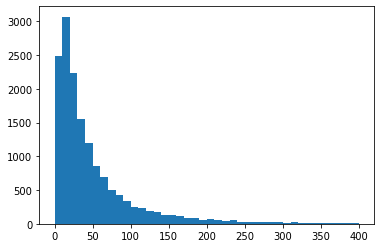

In [67]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

In [68]:
def emMatrix_glove():
    file_name ='glove.twitter.27B.25d.txt'
    size = 25
    em_index = dict()
    FILE = open(file_name)
    val = 0
    flag = 0
    for line in FILE:
        coefficients = line.split()
        first_word = coefficients[0]
        word_values = np.asarray(coefficients[1:], dtype='float32')
        if(flag == 0):
            val = word_values.size
            flag = 1
                    
        if(word_values.size != val):
            print(first_word) #debugging purposes 
        else:
            em_index[first_word] = word_values
    FILE.close()
    print('No. of vectors: ', len(em_index))
    
    l = list(em_index.values())
    stack_val = np.stack(l)
    st_mean = stack_val.mean()
    st_stddev = stack_val.std()

    word_indexes = tokenizer.word_index
    word_indexes_size = len(word_indexes)
    em_mat = np.random.normal(st_mean, st_stddev, (word_indexes_size, size))
    
    em_Count = 0
    for word, i in word_indexes.items():
        i = i - 1
        em_vec = em_index.get(word)
        if em_vec is not None: 
            em_mat[i] = em_vec
            em_Count+=1
    print('Count of embedded words: ',em_Count)
    return em_mat

In [69]:
def emMatrix_fasttext():
    file_name ='wiki.simple.vec'
    size = 300
    em_index = dict()
    FILE = open(file_name)
    val = 0
    flag = 0
    for line in FILE:
        coefficients = line.split()
        first_word = coefficients[0]
        word_values = np.asarray(coefficients[1:], dtype='float32')
        if(flag == 0):
            val = word_values.size
            flag = 1
                    
        if(word_values.size != val):
            print(first_word) #debugging purposes 
        else:
            em_index[first_word] = word_values
    FILE.close()
    print('No. of vectors: ', len(em_index))
    
    l = list(em_index.values())
    stack_val = np.stack(l)
    st_mean = stack_val.mean()
    st_stddev = stack_val.std()

    word_indexes = tokenizer.word_index
    word_indexes_size = len(word_indexes)
    em_mat = np.random.normal(st_mean, st_stddev, (word_indexes_size, size))
    
    em_Count = 0
    for word, i in word_indexes.items():
        i = i - 1
        em_vec = em_index.get(word)
        if em_vec is not None: 
            em_mat[i] = em_vec
            em_Count+=1
    print('Count of embedded words: ',em_Count)
    return em_mat

In [70]:
def b_lstm_embed(embedding_matrix):
#     embedding_matrix = loadEmbeddingMatrix(embedding)
    inp = Input(shape=(maxlen, ))
    l1 = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)
    l2 = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(l1)
    l3 = GlobalMaxPool1D()(l2)
    l4 = Dropout(0.1)(l3)
    l5 = Dense(50, activation="relu")(l4)
    l6 = Dropout(0.1)(l5)
    l6 = Dense(6, activation="sigmoid")(l6)
    model = Model(inputs=inp, outputs=l6)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    model.fit(X_t,y, batch_size=32, epochs=4, validation_split=0.1)



In [71]:
embedding_matrix1 = emMatrix_fasttext()


</s>
.
,
the
of
'
in
-
and
)
(
a
to
is
was
it
for
on
s
as
that
from
by
he
are
with
this
–
be
an
at
or
i
not
people
}
other
they
his
american
have
has
utc
also
one
were
which
but
can
talk
there
first
#
new
united
about
you
their
may
all
she
d
when
after
had
states
who
made
more
if
born
used
many
city
some
time
websites
two
t
its
most
called
b
english
world
been
no
}}
her
do
like
only
years
th
known
up
would
into
will
because
so
than
page
name
movie
national
de
/
these
very
such
should
?
them
we
then
team
living
river
part
state
!
rowspan
music
war
use
year
south
during
over
article
league
january
north
television
british
football
out
actors
france
university
where
march
what
july
rd
august
county
make
became
june
between
found
movies
pages
discussion
m
october
series
december
april
player
september
different
died
style
three
york
group
february
him
november
any
best
just
before
work
now
well
list
see
same
french
john
second
later
history
life
number
being
since
german
related
country
co

shot
useful
ed
question
holy
santa
del
machine
reasons
journalist
biggest
letter
nine
throughout
williams
saying
pay
longew
latns
ones
moving
placed
bot
yellow
du
fighting
raised
references
older
id
appear
chart
scott
logs
missouri
jazz
captain
legal
reference
sign
weeks
engine
heritage
easily
blues
meant
fort
skin
literature
revolution
effect
bbc
search
presidential
course
arrondissement
winner
oklahoma
isn
troops
loan
beach
currentclub
americans
meet
latm
met
harry
runs
eventually
longm
kings
upon
princess
evidence
individual
structure
cathedral
jesus
professor
appears
honor
greece
bob
kinds
physics
arms
acting
committee
friend
parish
tennis
ip
stanley
symbol
iron
physical
cat
piece
leaves
fast
grow
mexican
camp
dog
towards
industry
minnesota
destroyed
leader_title
leaders
climate
oppose
weight
ends
comedian
object
animated
tower
ball
administrative
turn
officer
awarded
passed
cover
instrument
https
nation
cut
easy
marine
vice
universities
nintendo
addition
double
letters
sport
compo

shared
southwestern
equipment
knight
ukraine
winds
poetry
radiation
invasion
soil
publisher
queens
clothing
sleep
mi
×
beyond
romanian
hitler
−
presented
representative
galaxy
affected
mars
warner
treated
lawrence
ryan
eating
ain
positions
plans
basis
touch
movements
tribe
austin
chamber
poems
immediately
motor
reports
charlotte
classic
senior
pain
maps
academic
platform
approximately
milan
peak
carlos
perfect
finds
sell
audience
voted
#e
plain
slaves
cats
standards
illness
speakers
benjamin
develop
represented
yorkshire
compound
seconds
meat
mercury
communication
goddess
_dst
potential
finding
reality
guinea
yonne
sweet
views
expected
brooklyn
traffic
bros
outer
banks
donald
stockholm
ending
pneumonia
figures
muslims
pp
scored
christians
attended
teaching
extreme
fit
financial
bold
jordan
alive
extended
solution
advance
alex
layer
cricket
graduated
pole
remaining
shortly
senators
performing
harvard
shark
orbit
returns
stands
moore
argument
population_as_of
bobby
ann
resistance
var
dra

organs
population_blank
arctic
isaac
tommy
userbox
personnel
locomotives
monday
wet
regarded
ms
sultan
composition
devil
checkuser
cheese
tables
defensive
sit
locations
household
dome
sees
genera
clock
infarction
harm
besides
fever
primera
derived
documentation
roberts
draw
holes
coordinates
patient
mixture
sacred
relief
duty
crossing
mask
farming
observed
lights
dame
gabriel
equivalent
locality
bread
drawing
myocardial
distinguished
newly
duchess
shadow
somewhat
estate
jet
tank
cuban
à
death_cause
rush
burn
campbell
oak
detailed
susan
launch
determine
duck
populations
disabilities
meta
altitude
lotus
metals
warsaw
auvergne
greatly
somewhere
montgomery
albania
somebody
leadership
regarding
cooking
technique
rocky
statlabel
explanation
aube
pointed
truck
photographer
accused
nashville
threat
anthem
papers
prague
anatomy
injuries
popularity
hosts
noble
experienced
regularly
southeastern
neil
mill
proved
survey
mar
manitoba
penguins
counter
shall
potassium
statistical
download
boxing
life

nowrap
vitamin
hey
responsibility
preferred
confederation
ranks
pronunciation
istanbul
revenue
indonesian
rider
credits
es
circus
naked
fundamental
herzegovina
rapidly
functional
christine
guitars
lucas
uniform
variation
fusion
maya
knowing
betty
survival
}}}+
nebula
superior
rates
den
johannes
briefly
earn
regardless
plural
conversion
mb
grampus
beetles
col
°f
sensitive
persia
rubber
das
owns
scheme
uw
faculty
opposing
practices
spots
pitch
maintained
ratings
shells
civilians
emily
concepts
pack
reacts
shopping
sonic
therapy
wealth
assumed
vatican
celebrate
seas
ltd
gallantry
winger
skier
noise
define
panel
swim
maría
attractions
smooth
tobacco
prussian
duncan
nile
performer
bermuda
ix
perth
jef
julie
chi
astronomers
grain
viewed
kidney
dos
abbreviation
jeremy
promised
sock
stalin
moses
phillips
rape
beaches
tanks
reverted
leopold
diagram
ultimate
mlb
watched
missed
sox
felix
disabled
caroline
libraries
georgian
nagoya
bath
opportunity
mcmahon
verb
olive
skiing
periodic
dissolved
coli

discovers
treasury
disruption
midlands
jake
rowclass
freeman
kashima
abbottabad
tehran
shimizu
polo
competing
rouge
freud
intensity
pets
rescued
exclude
bonaparte
nuts
current_members
shi
cpu
elliott
retreat
dictator
sailed
stefan
clarinet
chester
newark
milky
navbox
scout
veteran
michaels
shepherd
curitiba
gandhi
razorflame
xx
portsmouth
posts
relay
reserves
pulmonary
sailors
din
flour
respond
agrees
crusade
arrow
ideal
employed
tottenham
nicaragua
pigs
households
alps
gotten
racer
intense
gloria
marsh
decorated
doctrine
preview
aberdeen
reasoning
superman
cry
significance
vissel
qualify
palmer
aztec
twentieth
con
sits
repeatedly
unity
sally
josef
imprisoned
abbreviated
garcia
restrictions
guests
stevie
kit
caves
silva
celebrities
hormones
s/
nutrients
spears
lens
honduras
infected
nineteenth
developers
distant
oz
prairie
throwing
connections
coordinates_type
dried
grover
infinite
cathedrals
turtle
bisexual
sudden
sunlight
fraser
ruby
migration
sunset
membrane
gamecube
quotes
juventus

leigh
intercontinental
pistol
eternal
crescent
sandra
analog
cherokee
pr
keynes
bomber
punch
auguste
rodents
um
paula
illustrative
sockpuppet
imagesize
newest
apes
networking
insane
andes
engagement
unitary
dante
dividing
valentine
merger
nassau
beck
providence
dirt
indefinitely
neill
difficulties
clare
paraná
beside
heavier
russians
tobias
planetary
aims
nl
preceded
elimination
benin
oriented
crystals
witnesses
tornadoes
pérez
wi
neighboring
incorrectly
oval
lime
dudley
chamberlain
surgical
omega
sino
manor
considerable
segments
surely
buying
pac
sorting
midway
fourteenth
syracuse
vip
rodgers
cctld
burial_place
tokugawa
leone
seventeen
wondering
beds
funds
complexity
pianists
decorations
generator
adjacent
dion
gateway
erosion
elseif
biographies
appreciated
gran
auckland
fragments
lionel
segregation
constructive
announcement
lecture
manages
eduardo
denominations
authorlink
finale
garage
dalmatia
woodland
commanders
striking
motorway
blessed
nigel
sophia
ballad
wanderers
spell
firefox


wichita
priority
disestablished
rituals
ulysses
tramway
solids
ares
watts
fide
picks
rollbacker
skyscrapers
goldwyn
communauté
donated
associations
#ff
edison
lester
hillary
ecuadorian
byrd
gentle
yours
jubilee
feminists
cleopatra
gorbachev
hector
sec
steep
algerian
oman
loads
succeeding
bud
birthname
blanc
tones
editorial
salts
tellurium
knock
nocturnal
shrimp
stewards
spur
buzz
mackenzie
grapes
time_zone
cornish
leonese
lyricist
banjo
potomac
jennings
dramatist
britney
whedon
reunion
fulk
mcdonnell
sonny
splitting
socrates
heathrow
promises
integral
hdi_rank
realizes
gdp_ppp
pleasant
zoos
statute
abdullah
expelled
vaccine
numerical
operators
singular
altered
ngc
formations
questionable
gaining
inclination
britten
reflected
realm
cordillera
collective
clive
carr
warships
torn
schumacher
nasal
bunker
pixels
palermo
censorship
emerged
programmer
marguerite
guadalcanal
sink
emotion
siena
niece
qaeda
juvenile
shoe
bombed
inhabitants/km²
mutiny
clone
compression
maroon
wanna
attractive
sic

sumo
karnataka
hammersmith
dislike
satisfied
schleswig
ee
rs
remind
searched
bites
determination
américa
coasts
eccentricity
approached
lectures
grouping
litoria
tt
holdings
spies
deities
enrico
julien
unmarried
cassandra
constable
playboy
foo
kinetic
samaná
negotiations
promotions
ourselves
virtue
mountaineer
classis
slight
explicitly
rudd
paradox
impulse
darfur
gers
noir
garbage
brightness
elevated
kalmar
skinner
transform
neighbors
gambling
home_town
lanarkshire
cale
ric
bananas
opium
lawn
justices
watershed
bantu
qb
eritrea
colder
firearms
synagogue
algebraic
inquiry
aaa
completion
invading
burt
thesis
seminary
considers
endorsed
biochemistry
mausoleum
gunma
jakarta
guyana
deadliest
minas
sint
corrected
naomi
backs
yun
influenza
traders
forecast
dengue
grenada
kan
curry
tendency
mapping
episcopal
pork
policeman
shortname
fender
nm
operative
apostle
fury
chiang
ethan
posthumous
damon
induced
canadians
owls
tonumber
montevideo
ae
gallagher
explode
alger
barbuda
pattern_sh
meals
machi

fees
africans
octave
welcoming
believers
nf
inhabitants/km
parts_style
evolve
sour
ulrich
hahn
scala
cart
eton
population_rank
competitor
logging
fidel
campo
logos
pcupdate
hiddenstructure}
stimulus
billiards
creations
madeira
luisa
mentally
electro
/}}}
realism
charted
rpm
vargas
mast
printers
louder
fowler
ventura
nationalists
boring
sinatra
schemes
τ
hamburger
lantern
rowling
ri
alignment
trough
rift
lecturer
ramsey
systematic
dansband
antibiotic
pigeon
ceylon
rewritten
aladdin
spiny
protesters
martínez
bout
tender
kanye
vibration
emir
ozone
microscopic
nurses
brotherhood
helper
tapes
incumbent
burden
controllers
che
exercises
desmond
illusion
starch
pasha
togo
comune
saharan
baxter
exo
emu
djibouti
screaming
graf
correspondence
milkweed
uploads
eyre
ala
bored
broader
understands
deposit
bk
mop
mainz
hydrochloric
tex
calabria
massif
encountered
cf
sig
databases
erected
sinn
lasker
vezina
referencing
bluegoblin
anatolia
linden
visually
stripe
drummers
professors
arise
modena
estadio


boar
definitive
brennan
procession
hdi_category
climber
nou
schooling
remembers
salon
goldsmith
eugène
mara
knighted
oder
pulau
keane
acton
rae
clarification
enhanced
gong
dart
hawthorne
musket
seafood
photographed
caldwell
conventional_long_name
primes
monsoon
appendix
murcia
image_width
wasp
ritter
noc
synonym
downloads
candles
bypass
mccoy
glue
readable
freeway
refusing
seamount
bede
covalent
fairfield
catches/stumpings
prosecutor
donovan
translating
bowler
jimi
pops
maptitle
climbers
seating
comedies
pritzker
cheng
murderers
lobe
venezia
swept
wally
relics
miriam
balloons
passport
orgasm
ui
ejaculation
francesca
soy
kelvin
em}}
erect
crews
observing
glover
galatasaray
caliber
lifting
vita
leicestershire
fern
brakes
phi
vintage
\right
swahili
emails
badger
ganges
grateful
num}}
failures
mates
preliminary
brandy
importantly
outlined
hearst
violins
franche
drill
comté
smoked
steamer
brandt
emergencies
ridges
disagreements
nitro
iconic
barley
scenario
antagonist
mentioning
wikia
newcom

drank
sikkim
firefly
intestines
shifts
sakura
specification
furry
pegasus
paisley
wainwright
christophe
parable
ribs
nan
urgent
coro
rousseau
dull
forensic
backlog
←
bulgakov
dining
babylonian
études
brasileiro
pune
compulsory
tore
clitoris
ferris
oc
ninety
ads
elm
mined
chopsticks
adhd
spl
billionaire
hygiene
beauvau
blender
iroquois
eisenstein
goiás
tallinn
hilly
graubünden
templatename
cured
specifications
atkins
superstars
fargo
flagship
ministries
all,
atheism
nunavut
caicos
len
hiratsuka
inverted
siemens
jensen
indigo
rhin
mehmed
soto
disguise
schoenberg
murad
massey
handsome
alyosha
eels
unmanned
bunyan
puccini
receivers
ito
allende
correspond
continuity
spontaneous
ripley
scorpion
allegro
shoemaker
radial
finch
gears
impacts
hotter
artworks
lech
answering
thérèse
starfish
kv
lrt
lastly
casablanca
recalled
coldest
}}^
bullock
gal
sumner
upstream
transmit
woven
lambeth
judea
antrim
charm
fermat
manipulation
tae
bodily
picnic
orthodoxy
laughing
researched
struggling
ashore
eisenac

soyuz
reluctant
paraguayan
repertoire
narrated
premature
slows
göring
lautrec
engagements
tacitus
capra
herbaceous
lim
emancipation
nationalities
elgin
bragg
purplebackpack
trier
perch
kiel
pinochet
forge
episode#
preparations
penelope
cornwallis
sulphur
espionage
caligula
plots
émile
saturated
pliny
fluorescent
discus
crewe
ashford
spokesman
wagons
björk
rostov
cocktail
abby
vincenzo
junta
jfk
gotta
bucks
caucus
lottery
submachine
astor
ac/dc
machida
amd
hilbert
vt
cacao
nationalliga
dorothea
chancellors
doncaster
figaro
capcom
anthrax
bochum
grail
himmler
hardcover
floats
leno
munro
amir
amplitude
flickr
disqualified
rightarm
suplex
causeway
syriac
conquers
seaport
endeavour
comunità
portman
kerberos
hq
vaginal
bolsheviks
detectors
nikolay
priory
pickett
bernini
triton
bam
meningitis
disposition
dumas
père
jeremiah
doha
cyanide
bengals
jagger
janice
papacy
dane
imho
vorarlberg
banded
coil
cosmology
hippo
prompted
refusal
coritiba
rewards
maze
womb
wallachia
slides
wit
saliva
archdioc

plumage
homosexuals
financially
wren
suppression
satoshi
pullman
germanicus
ffff
lorem
amazonas
novo
inlet
iupac
ambiguity
poppins
ilyich
analogous
congenital
kgb
saltwater
farina
dina
hypothetical
workshops
krebs
passwords
blaise
algiers
orr
atatürk
hearted
tunis
paternal
englewood
bump
liturgy
samba
pods
closet
syzygium
bully
dusk
sampling
engineered
subdivision_ranks
idiom
metadata
pancras
outcomes
protesting
cartwright
brentwood
neurologist
nightmares
barbecue
fabrics
champlain
reservations
evanescence
ratify
engraved
inability
jewitt
translators
marginal
greedy
iuserosary
middleweight
polynesian
asin
nicolae
risen
bridgestone
hieroglyphs
taoism
advisors
katana
deccan
prospect
ish
condoms
#eeeeee
mammoth
remakes
redesign
monterrey
behaves
baleen
hyperion
roberta
historia
sayings
spaced
expresses
teammates
embargo
savannas
tm
hato
har
first_aired
kissed
irons
creativity
torso
iwa
obj
trader
absurd
elongated
charting
gesture
imitation
vallée
ducal
contraction
gastrointestinal
unchang

barre
humorist
velar
groom
subtemplate
lovell
entertaining
daxter
yue
prayed
cant
cadets
abramoff
list_episodes
rehearsal
interrupt
coquimbo
diddley
gras
philatelic
clarisse
viacom
comprised
jovi
stalls
filmography
newts
spheres
pagoda
stepmother
assured
yangtze
waterways
clements
commodus
springsteen
jainism
friesland
recruit
clemens
dives
leighton
bakerloo
dissident
kazuya
lds
dummy
roasted
presentations
pity
leased
nostrils
contraception
mane
roquefort
beaux
aesthetic
heap
soho
symbolizes
taishō
saarinen
schiller
tierra
chancellorsville
silvery
anguilla
gujarati
ode
rubbing
lute
hrh
guatemalan
giraffe
bubonic
offend
neuville
♫
sauron
woogie
easternmost
wombat
volatile
omg
scars
simeon
bog
canaan
arne
duplication
selene
healy
carinthia
kasparov
daring
brig
benoît
verrocchio
marconi
pb
farmed
backbone
withstand
rig
ounces
cognac
trotsky
hardened
zur
rhapsody
chipmunks
marais
melodifestivalen
installations
veterinary
reinstated
felis
nana
benzene
pseudo
deco
operettas
powderfinger
cran

ramírez
gdp_nominal_rank
cornelia
total_type
dunfermline
castes
environmentalist
psychotherapy
zanuck
mississauga
sightings
bradbury
pontius
breslau
placebo
thoroughbred
indentured
ora
personification
steak
karin
xerxes
slap
tosh
ieyasu
waldorf
nonviolence
cryptanalysis
advocated
derry
mein
gigantic
lend
billington
backhand
accuse
scarf
hondo
accessing
bl
reuben
teutonic
callaghan
ath
counterpoint
modesty
etiquette
imagefile
barren
spiderpig
preached
redwood
almighty
bayeux
acne
eur
isolate
rodrigues
repealed
lahti
advert
avian
surveying
sweeping
maison
wim
sadat
eine
lear
extremist
mites
worded
neuroscience
sasuke
ops
nutrient
skateboarding
surface_grav
ecgfrith
rohan
anatomical
tycoon
gödel
ruben
jacobson
niches
ascent
prades
nec
parallelism
whisky
appleton
conversions
empirical
frontiers
fencer
stresemann
excommunicated
pebbles
bashir
goths
serenade
affection
woodford
lizzie
schröder
enclave
golan
scanned
howitzer
noisy
jure
implements
horsemen
sundsvall
ukrainians
competent
brownis

vibe
cae
dordrecht
schell
tohoku
gladiators
carpathian
rubik
cuvier
callisto
selkirk
vane
corse
samara
rapture
synagogues
ostriches
inherent
inject
hantuchová
godwinson
mallory
zionist
standardization
mathews
omnivores
utensils
swine
expressionism
storylines
ö
burlesque
osnabrück
bestseller
ampere
stimulating
polarity
kelsey
transverse
bcs
tuba
litres
geneticists
redirection
wiz
dragging
imminent
biscuit
ophelia
roadside
showers
anticipated
assassinate
hillside
tp
estefan
nellie
bassett
jihad
electrified
sabana
hounslow
turkmen
dickson
carcharhinus
penetration
belvedere
leblanc
flag_p
giuliano
tee
turquoise
chakra
kaohsiung
hounds
partitions
cassie
alaskan
positional
inadequate
reuse
cutler
lamarck
gilman
barnsley
cuneiform
otome
thirsty
cultivar
centrale
prosecuted
cenwalh
falsely
agrippina
evelina
archeological
fordham
transvaal
lindgren
evils
alistair
eurocopter
nell
adolescents
theorems
machado
musicologist
mayall
valverde
sauer
generalized
enjoyment
isaacs
hallows
doughnut
saltire

munster
#there
burial_date
pepe
durban
lippe
svetlana
auditioned
anterior
hymenoptera
gangsters
peaches
watertown
polonaise
regulating
assyria
courier
octaves
dwellings
synthesized
lagoons
italo
poitier
placid
grudge
krusty
residing
almeida
parti
tenshō
rococo
relieved
motel
haji
psychotic
savior
hyphens
husbandry
mcconnell
avellino
beatty
hilal
regensburg
adr
cottages
lower_house
drunken
prahova
scrutiny
xin
seton
ignores
wheldon
sorbonne
grabs
savile
bocage
fb
specializing
dauphiné
bethel
routing
torpedoes
saab
antiquities
tetrapod
plateaus
ribbons
sighting
deb
halen
mcgee
subcats
hectare
metastasio
gadsden
neeson
bandits
salim
apricot
hirsch
\theta
hurling
tampere
administrations
merced
yanmar
cleo
partido
resistors
date_format
goguryeo
guan
\gamma
lilian
nanotechnology
reuter
vivaldi
overturn
textsize
monticello
electrically
bir
standalone
brodeur
bufo
dagestan
malmaison
connective
laughter
hydrothermal
perjury
mixer
population_note
owain
hurd
ludovico
rein
gita
obstructive
daimler

stinging
tempted
contradict
huns
warrington
glados
lightyear
jana
amiga
andrey
xiang
cabinets
comcast
ehrlich
venerated
aphelion
centenary
parton
fortresses
milder
c/
salaries
amu
anderlecht
constructions
dashed
artistid
mastery
clarendon
hiro
danforth
severed
concealed
scientifically
iroh
oblivion
mildly
camouflaged
mexicans
ffc
tobruk
pounder
pearce
eo
terabithia
silenced
prev
civilized
flagler
rachmaninoff
complication
siempre
coimbra
ester
musume
norodom
carvalho
kano
ganesha
hb
quay
batavia
audubon
positron
naginata
samarkand
tedious
immunology
melanoma
forcibly
kenobi
imp
bionicle
kelp
marquette
gainsborough
chiswick
sonia♫
mails
vx
epa
hideyoshi
motivational
marmara
gestalt
rapa
suk
lawton
flavours
lint
proliferation
candies
talia
rooted
nonvocalscream
deus
nath
pluck
rei
eure
keisuke
aldeburgh
paradiso
custard
translucent
confederations
stereotype
slips
jagged
musique
depressive
northwestward
ufo
figurative
gh
dorus
nanboku
thant
undeleted
peptide
lomonosov
takahiro
menuhin
som

freelance
demetrius
crichton
gastropod
memberships
astley
codename
sandoval
au$
futebol
furthest
differed
phnom
warranted
sedgwick
instincts
elam
minted
dolby
motifs
gainesville
frye
armadillo
insider
willows
saleh
youths
lisp
dbs
rehab
grevenmacher
religious_affiliation
recommends
fogo
caudal
slabs
trofeo
aykroyd
fils
psychiatrists
guelders
replying
battlestar
eri
cookery
limoux
loudspeaker
wormwood
dislikes
waals
haymarket
harju
aesop
chiricahua
bec
megawatts
wnba
ogre
peiper
kombat
forerunner
etta
mehta
landowner
lordship
dept
pricing
ionized
acetic
ziegler
hackett
chunk
warts
cee
colegio
basie
valinfo
dialing
bellinzona
gluten
caller
husky
unto
luxembourgish
guanacaste
honesty
baldur
mamluk
polyphonic
girons
wikipedia_api
kfc
optimistic
digested
caliphs
sèvre
shemini
divisor
accommodations
tile
castling
rotunda
rémy
magpies
jethro
frightening
softly
postwar
refreshing
olympiacos
dysfunction
amethyst
rehearsals
hove
hmmm
superiority
chūgū
mamie
matheson
grisi
weiner
interpreting
tam

rolla
tarragona
adopting
erickson
qazi
introductions
marbles
revolted
escorted
agha
godmother
frankfurter
lutz
linköping
corrie
gutierrez
aisha
linebackers
ferrero
pohjola
cullman
hindustan
hustle
tampico
llywelyn
centrist
sculpted
chalmers
marital
naxos
booknotes
fates
eilenburg
foiba
sounders
mandaeans
deafness
gimme
preschool
besançon
devote
school_tradition
cranach
lemons
ordeal
jardine
flatfish
carlotta
на
bischoff
elizabethan
ro/
belsen
paulus
nitrous
muses
website_title
kwazulu
foreword
psychoanalyst
frauenfeld
pyle
mowbray
rtl
hijra
reworked
°r
anzio
dior
weekdays
mather
isotopic
cosine
bathory
mahfouz
undeletion
shapiros
lindy
wrapper
barefoot
licensee
dons
plácido
bridgewater
feliciano
sahrawi
nlm
colby
empoli
päijänne
annunciation
firefighter
neoproterozoic
lorna
mesopotamian
taichung
iglesia
twists
durrani
trimmed
salo
neu
cremation
košice
roxanne
nubian
smyth
templatedata
flatter
asserts
usenet
roxy
darin
septactamta
chechnya
meps
interestingly
notts
felice
sucked
ugo
geno

arras
cotten
alesi
aymara
ibc
ustashe
garnet
neanderthalensis
hath
septimius
hashim
maryam
motocross
flavoured
mcclure
noriega
restricting
sucrose
lat_s
flashing
kernel_type
lennon/mccartney
marianas
karthikeyan
snare
honeydew
preset
dummies
diarist
date_end
kor
alberti
saraswati
boutique
solemn
axial_tilt
carthaginian
oecd
hino
qm
amory
craon
altos
cuevas
pica
invitational
regia
ginza
duma
nerva
reforming
lennart
chí
gauntlet
orbison
conferred
it´s
\psi
landsman
crates
humanoid
wonderwall
b+b
pointers
incidence
gleason
crawley
algonquian
elegans
trademarks
taglioni
lina
lamont
taps
astrodome
viscous
porte
fdr
dedicate
bullies
sophocles
gastric
sexism
celestus
gießen
mantra
mailed
webkit
transposing
clarinets
whipping
fandom
pontevedra
baer
laufenburg
ffcc
restraint
disposable
hanneman
midtown
darwinism
exe
cinematographers
quercy
yt
guinean
gn
decrypt
\vec
yekaterinburg
frieze
spitting
sultans
sassari
fujimori
amarillo
apocalyptic
azkaban
benevolent
amato
free_type
scooter
reluctantly

newline
leopardus
neuroscientist
thiruvananthapuram
idf
workmen
goody
hih
waffle
xiamen
ft/s
gwinnett
argonne
vallecano
parted
rota
medlineplus
gma
birdman
wali
polypeptide
luise
retailers
arashi
ronin
ces
saqqara
cheapest
exxon
prong
testified
jm
jt
vandenberg
genitalia
countesses
fascinating
nkrumah
maputo
gasteiz
spadefoot
netanyahu
montesquieu
bigfoot
potenza
kwame
heinlein
/talk//
trolleybus
layne
high_school
mayhew
springtime
chairmen
dostoyevsky
mentifisto
imagestyle
conduit
tawny
cooley
discomfort
obwalden
quota
ochre
frasier
clarifying
impala
xiaoping
nicobar
incidentally
positivism
ramone
poo
fireproof
oversee
braidwood
ferb
ouagadougou
rarer
urges
puce
chou
corazón
discoverers
undid
painkiller
circulate
heike
shibuya
somoza
exponentiation
nemorino
unlinked
borealis
blackfriars
scriabin
testicle
jib
pickups
gad
mods
meles
gaveston
tartar
atrium
horny
ruskin
allt
carrington
lat_m
alveoli
enryaku
borrowing
bodmin
sentiments
fulgencio
lautenberg
weald
sprites
medial
meh
ingvar
u

girders
amores
bolesław
lemmy
kathie
inspectors
chessmaster
yoshiaki
uphold
kunieda
swanhilda
aer
ralf
troubling
abstinence
rosberg
dentists
conversely
flashback
weddell
tbennert
dobbs
sardinian
halim
alford
critérium
conde
fro
spilled
cybernetics
får
overlook
deepak
bangui
wasteland
ibsen
bachchan
bracken
savarin
göran
rents
clapping
pollinators
emplacements
tumulus
deemster
logistic
longstocking
supercluster
abbasi
rang
mor
thoracic
presidente
flashlight
raine
mcafee
blasts
santorini
aare
lalo
invoke
beatle
laver
investigates
tilting
kegan
abscess
tracing
cushions
aragorn
andover
harassing
gypsum
adidas
ghalib
registrar
pryce
tokio
sip
snows
bertie
vajrayana
chaim
borrows
xie
hpv
insignificant
hajime
lerman
cornus
leven
renesmee
dulcamara
buf
l}}
mcshane
parthenay
rancagua
inductive
pegi
shere
sportsmen
cui
voix
eugenie
toms
herm
pauly
harz
honky
innuendo
midler
tantra
proposer
annecy
sarin
jimenez
wattle
tenji
lubricant
parentnode
entrenched
outkast
abs_magnitude
boardman
ning
alken

lccn
widows
aumont
josefa
spinoza
carloman
hindko
jeune
liqueur
temp_name
spheroid
sanctus
beauchamp
opentheme
prehaps
armorer
berets
quagga
cheaply
boredom
biofuel
skateboard
firepower
sativa
quack
crochet
insecure
checktype
leyden
aidan
alix
brookline
cordon
altars
berlusconi
genki
epidemiological
maddox
bernal
neulengbach
ouen
eyck
date_start
bayne
cellists
congrats
dowd
ultima
vixen
prvaliga
lovins
provo
tsarnaev
jeotgalicoccus
footscray
crotalus
songbird
koga
wea
asquith
czechs
conviction_penalty
incubator
therapsids
ilford
koror
koshi
irredentism
advantageous
acadia
boers
harada
khunjerab
tuck
gresham
alliteration
marcella
jhansi
singlesrecord
zwolle
company_slogan
ansari
mccloud
brownie
oki
paix
gremlins
superleague
balkh
hjalmar
intrusive
atc
exposes
wikifying
mayday
venera
karlheinz
watterson
watering
cryptic
breech
octane
brfa
fujieda
setpagetext
jintao
pugh
vuh
ecologist
atrophy
oddly
ouse
katarina
eggplant
vara
suborders
tremblay
tarrasch
nostra
wisconsin–madison
alsatian
e

tauriel
jyutping
☎
kaltjiti
peppered
octet
/the
slippers
departement
bruegel
jazzy
westside
arrhenius
lambing
nguyễn
thule
indexing
nucleolus
haste
barbosa
kampen
carnarvon
backups
yamuna
layton
nightfall
nutritious
brahmin
mattias
paramedics
spooky
widths
houseguest
jehan
curled
spvgg
faro
architecture_style
tengwar
zagumny
colombe
reversible
lends
accelerates
aubenas
leclerc
michelson
hala
cronus
sawchuk
iridescent
upsetting
platforming
inefficient
mum
furlong
//news
alcock
mab
hlinsko
inconvenience
rubs
megalodon
crohn
brito
deliverance
bateson
qualitative
zaglossus
fredonia
ducking
misawa
osi
refurbished
transfusions
euskadi
interprets
vanda
marussia
greenock
sped
martinus
lipped
yushchenko
endeavor
sabaneta
goldschmidt
outweigh
goebel
entrants
nive
onerepublic
democritus
budgets
lucio
tasked
aldwych
berthe
oaths
esox
platino
udp
thouars
chopstick
embarked
harare
české
injunction
standoff
prem
soames
easterly
predestination
halide
strengthens
goldeneye
hyphae
valuation
länder
revol

quartzite
koffice
tackled
zofingen
razors
apostasy
pox
stereotypical
grawp
lenore
narcotic
lederman
tempe
olympiads
forcalquier
vaz
page/article
doremi
cultivate
obtains
osprey
antiquarian
emphasizing
drusilla
reminiscent
polotsk
nouel
wilcox
delphinus
dukedom
com/issuearchive/
unharmed
approximations
cicely
,}}}
bardeen
shaunessy
paice
moonsault
yee
nakúm
alum
c+c
snowdonia
arduino
retreats
redness
normalizeds
source_lat_ns
pago
limousine
catering
previews
ejaculates
mackey
sunnis
birinus
catheter
farnborough
collectible
astonishing
pilote
parabolic
m/
grime
pittman
yutaka
macroeconomics
sununu
mdma
avions
findagrave
haw
ucl
bellator
plotters
collared
/gim
dutt
blackstone
ōmiya
carat
squall
junkyard
alters
_alt
baboon
kz
suc
uriah
makkah
ryota
intersections
petting
schön
dafoe
hox
adèle
flagpole
extraordinarily
ethane
haan
ericsson
vervins
main_group
kingman
persist
backbreaker
highlander
caracol
tart
annotations
aspiring
shortlisted
romances
botoşani
exited
mouth_long_ew
nomad
winkle

colvig
amati
fabius
larouche
faux
piedras
stategov
plantains
melanesia
suggestive
donut
unoccupied
bentham
voltaic
productively
ockeghem
mimas
compressive
notary
dufour
berle
bungo
hud
deterministic
punks
poj
evangelion
muti
primeval
mymensingh
anschluss
clays
jiao
state_assembly
generis
hélène
cuentos
asad
redstone
scoreboard
clump
couscous
eccles
litchfield
scotts
valli
isc
topologies
ibis
salmson
soaring
thalidomide
leathermouth
skinks
bose–einstein
oxytocin
schinkel
anni
shamanism
monseñor
paddles
#william
seagulls
jourdan
heliport
viterbo
ipass
botulinum
ovulation
weismann
jacobins
olmos
fastreverter
nevsky
oxidize
_ref
fragrant
boldface
cleanliness
unearthed
hypochlorite
afflicted
rho
farragut
chaparral
axelrod
seagal
varuna
bahía
boromir
arn
terrifying
billups
haitink
muridae
senatorial
seri
mcewen
distrust
sentry
walkways
alfaro
sak
abolishing
johansen
hōji
allgemeine
seppuku
astounding
tibor
beechcraft
janne
obligatory
dormancy
hugs
seeps
paume
tricolour
mirroring
florey
sagam

leadbeater
tarantulas
solute
bristow
uncategorized
checkusership
ashram
glycol
melancholia
zoltán
kalevala
déjà
creams
kosciuszko
amputee
stralsund
charentes
reitman
falköping
cnrs
grandeur
bhushan
abridged
wrangler
öland
funker
teague
balkline
solon
moltke
ranches
toros
sattar
cul
fingered
coulee
gies
charlottetown
imperial/us
cowles
ß
adaption
aptitude
tamworth
ionia
seriatim
cano
eunomia
zong
aviva
magister
eastwards
qe
outcrop
reckon
koki
pip
raye
lisboa
bessemer
majorwins
tuner
mummification
cheletropic
intermediates
irregularities
phased
kelso
fleur
torsten
prograde
atrial
specialises
diluted
thiamine
usurped
komnenos
^^
adhesives
symbolises
lamiaceae
hannigan
recep
tayyip
navigating
dropkick
nuestro
jervis
omim
repetitions
ediciones
talagang
prawn
acquainted
planktonic
padrón
krefeld
vsevolod
chancery
\pmod
juba
mickie
coucy
janata
ballon
moir
balkar
visigothic
includedworktitle
b^
linga
independência
anker
macdonnell
hässleholm
misplaced
casually
hōreki
ivers
biscop
nyssa
onaga

dompierre
bacteriologist
eines
castellano
billingsley
perales
messner
vence
agnelli
ouche
pirkanmaa
lourenço
chainz
chlorite
arslan
shota
júnior
yixian
statistically
malenko
estrellas
velocities
greyhounds
vesnina
jails
graaff
unrealistic
chairwoman
nationalisation
protectionist
polska
karolina
sperry
stockbroker
#they
horribly
snowballs
frazioni
ingested
banat
parliamentfor
raritan
copperfield
phosphor
cac
mend
upbeat
calment
herder
luang
radon
mesoproterozoic
crumb
hypotenuse
mcw
adenosine
latour
carrillo
edd
alana
soapbox
tatra
audible
log&user
beltway
frankston
flèche
mannar
editsummary
güell
block&page
concerti
eupen
babos
billz
sävsjö
trot
mcdiarmid
fishbone
errorsyear
escamillo
celibacy
gev
pantera
sneakers
banksia
}px
rayne
manmade
esoteric
cynric
kawashima
waltrip
ibrahimović
balalaika
dort
rohirrim
achillea
falla
extensible
asakawa
hauer
carbide
persists
scratches
bouquet
rfbs
vestibular
lso
squeaky
dollhouse
serviced
fraxinus
memorize
feliformia
berzelius
sludge
mockumentary

muranaga
farben
pxweb
grito
ch/selection
stilwell
px_language
de&px_db
riverbank
scotti
fagan
stocky
jentina
production_date
unheard
malinaccier
spantag
dismember
d#
daulah
authenticity
augusti
ornithology
vendor
r^
monochloride
sup
götze
sporty
niš
ewald
lengthen
kandinsky
zw
pontifex
kuusamo
eradicate
chipewyan
lazar
zoning
oblate
shkodër
nippur
gorica
fishman
wasikowska
divisive
#how
webcomic
kleybanova
profesional
ryuji
meteora
gar
anke
azarenka
barometric
perbang
uterine
ccff
auk
mikita
spelman
quant
miri
ange
academician
saybrook
mccrea
prognosis
donating
dromaeosaurus
accomplice
lender
wiese
glycyrrhiza
interpreters
sangmu
concentrates
drm
overflowing
hatchlings
ceauşescu
escondido
aurochs
degraded
brăila
philatelists
fatimids
messe
festina
elysian
ive
crespo
plywood
pittsburg
ticketing
hadrons
welwyn
monod
eder
marth
indium
snider
laysource
hialeah
anonymity
sunnydale
badwater
domingos
phong
wk
piccolomini
nyong
calvary
philatelist
thebe
markt
anacostia
chemin
nama
gnomes
chemi

genna
dyslexic
chrysostom
woking
fabiano
narwhal
gestational
supervisory
aceh
uerdingen
subunits
amide
vitale
tsuruta
khama
ica
chameleons
swigert
almansa
vaccinations
soucie
hildebrand
bamako
translocation
mvc
cepheus
iodic
matthau
xenophon
matty
byproduct
suda
thrilled
landlady
shaquille
standpoint
exchanger
kawachi
kefalonia
sirhan
sedge
unwin
tutors
años
nautiloids
ivanovna
murry
cherenkov
joensuu
rena
carbonic
dismisses
katrineholm
scifi
iwaki
yggdrasil
urbanized
veiled
yokozuna
deriving
mullally
ambroise
wernicke
syphon
sutoku
reinforcers
ringmaster
yamashita
forbach
attachments
duis
mumia
ellipses
ovechkin
locobrakes
hereafter
inkjet
vesicle
épée
messmate
charlize
echigo
reichstein
sobek
/a
comorbid
dissonant
cheka
flirt
avallon
dienes
câmpulung
scuola
woden
isner
belafonte
voest
ancien
kewaunee
hakan
wpa
tornio
nelle
midfield
vegetarianism
⁄
seeker
willibald
\in
gait
sycorax
coloratura
kilmainham
mbit/s
transylvanian
asymmetrical
kampfgruppe
rodman
dass
cerise
évreux
widget
dis

sabri
sargasso
jehol
vandegrift
masaryk
andronicus
leekie
beriberi
bibliotheca
centimos
elevation_max_footnotes
patio
disambiguating
rationalism
anchovy
escalated
gouverneur
pringle
shanahan
jost
brynner
mamluks
specialise
hyperlinks
weilburg
pampanga
eula
benicia
dama
uy
amado
aino
gripping
demarcation
lithograph
cvs
_altamira
judean
prendergast
avr
psychologie
irène
awakened
shrinks
jordin
camry
gris
#sure
aon
bunroku
silvestri
gramme
/hey
ndash
floss
mujibur
granit
rheumatism
ohata
crafty
sinned
vlorë
katrin
#ifexpr
hudgens
sauvage
sadaijin
north/south
kōwa
wineries
midas
hobsbawm
danaë
edin
predetermined
delocalized
panelists
dammam
mannerist
berenstain
perilous
sviatoslav
mohamad
vasconcelos
praga
plataea
pseudocoremia
meri
eishockey
headbutt
unready
suwałki
locmapin
hickok
ethelbert
adipose
yıldız
phenylalanine
ceredigion
nankana
margie
gigolo
kōmyō
helgoland
fictionalized
hasse
newsam
buëch
subscript
flared
ornamentation
benoist
khayyam
pra
nong
branigan
ornament
turkestan
croth

sectional
amphetamines
streetcars
piedmontese
antares
fenwick
reconstructions
delores
pulmonic
shultz
showgirls
rnc
crédit
akranes
loggerhead
flawless
evey
natureserve
homing
gudrun
weekes
kirkman
charta
evangelicals
anduin
murasaki
holyfield
rind
deadlock
iserlohn
düren
brompton
narayana
handlers
unholy
seiko
nagaoka
disruptions
venoms
delos
negroes
jimaní
bashkir
bimbo
tropicana
cunt
surya
hdis
ccha
centric
asus
armeniapedia
inspires
lapps
waukegan
haddock
kingda
campfire
grana
//git
grubbs
schemel
printable
audie
schott
namesep
mem
analyzes
korçë
amparo
turbay
merrimack
desolation
overcrowding
baskin
glassware
greasy
matthieu
doorways
monumento
roding
arcachon
andronikos
joakim
ningbo
shō
substring
geppetto
pedagogical
treachery
shrove
histology
battenberg
vaishnavism
mathison
shiite
triglav
lighted
qianlong
putintseva
silveira
bracelets
imbruglia
unaided
saskia
minette
overriding
kamala
sebring
in
bagno
khakassia
lammermoor
km}}
matsukata
briscoe
defibrillators
loosing
blazy
selve


wuerttemberg
completeness
terrapin
noto
eckert
anteater
bundesverfassungsgericht
poroshenko
suomussalmi
treasurers
gulch
//data
alumina
tapert
delius
gluon
hoyle
tiered
makassar
papandreou
lappeenranta
cmll
lz
dissociation
folksong
malick
mismatch
kohler
winglets
leeway
axillary
grammarian
toshi
condenser
freezer
dicdefs
cuauhtémoc
oir
merino
rania
volcanology
eminence
vhf
vibhushan
onscreen
constituency_}
nanga
friedkin
mitra
aardvarks
hainish
nca
sparrowhawks
hachikō
nappy
gardenia
fanbase
computable
seduce
adaptable
glutamate
wanders
fromage
dailey
knvb
polynesians
plus/minus
jihadist
bluesbreakers
sieges
detachments
conveyed
royston
livres
stf
starwars
volumetric
bsl
peschke
avranches
thiérache
ajdovščina
rehearsing
constrained
viscera
litigants
lychee
infantryman
monthey
prüm
brinkley
\infty
armavir
molde
picado
joann
shou
notes_exist
maithili
defibrillation
dissonance
spoilers
bromides
nws
remission
nelvana
schwarzschild
weevil
crj
drosera
baumann
varley
senhora
cherub
siân
islas

clu
puffin
leoben
scl
kopp
costero
needlework
musicology
groupn
summarily
curthose
cham
båstad
baldassare
arabidopsis
longhair
fishmongers
fulbright
dfa
dela
astonished
taklamakan
spacefacts
spg
rad
mephistopheles
dumpling
kenney
siouxsie
badakhshan
fes
judit
kika
roode
tamarins
stritch
ywca
shutters
mariusz
amoebozoa
telstra
ustad
faramir
limbo
ceiba
preparedness
bashkirian
efron
koechlin
underfloor
anak
lluta
yaqub
drei
restraining
godard
takedown
radha
camperdown
hôpital
batmobile
foreland
uomo
lcc
hülkenberg
kōtoku
contend
buckeye
xxxvi
loanwords
leeuwarden
ammann
gritty
aibak
bolted
true}}
neuropathy
floris
hangu
occupiers
iphones
tindall
teleport
telemark
ijsselmeer
rosalynn
#switch
talley
diagonals
envoys
tachibana
terceira
bristle
lindstedt
vän
vieques
manures
simrishamn
deactivated
hypersonic
elihu
alternator
regenerative
bacteriophages
huế
rcdb
acr
fane
\t
schmitz
patagonian
quesada
urartian
ennepe
reinecke
metlife
brisby
kroll
sculpting
njt
lurking
suse
frills
industrialists

chaux
maltby
eee
niedermayer
capella
navigators
includedworkurl
marchant
hof_player
gentler
misspellings
caveman
krater
shelbyville
smits
abo
metaphorical
homology
benedictines
campanile
charli
paeon
cartwheel
jadeite
greyson
ghiaurov
dsv
televisión
withholding
gamepro
epte
över
heartfield
kōei
conf_champs
fishbase
bijou
sabretooth
bzö
bonzo
bioavailability
exalted
bathsheba
crystallographic
biagio
kretschmann
#issue
ombox
angular_size
kross
cellulite
clemency
margay
injects
gampopa
kershaw
macross
indents
zp
lariviere
ninjago
dadra
staffed
magick
toffee
wappen
wrinkles
slavey
dou
lassalle
trelleborg
sommar
repo
dogrib
einin
nyan
balmoral
mears
nanteuil
agronomist
associazione
nowe
ewp
ladislav
blakey
petrology
northanger
domitius
yewtree
valance
greywacke
ephemeral
garching
writer/director
folktale
simonsen
mythbusters
anghiera
lossless
burnie
isao
odorrana
dubna
timeframe
unrated
siouan
ductility
sv%
bełżec
kozak
underdogs
phidias
squaring
strangling
considerate
bucaram
attaining
rai

epp
khadijah
pinched
musso
}}}}}}}}}}}}}}}}}
wreaths
pinhais
rajouri
umatilla
yasushi
xfinity
sigeberht
marchetti
spammed
menes
vannevar
worf
otaku
milagros
cosmodrome
hurdy
linköpings
centwine
talmadge
herzliya
embark
giuseppina
burghs
unum
likened
walpurgis
essequibo
witham
synths
wasg
ligature
general_contractor
painless
fortitude
sassanian
diversify
sportsreference
pyro
talkin
mcknight
auden
communis
nowell
raimundo
astrophysical
soulcalibur
metallurgist
priscus
holness
permissive
culmination
rocher
naminé
starsky
piled
maryborough
reynaldo
marthasville
kōfu
ethologist
bucyk
tengen
atheling
kinematics
lifespans
mirador
molested
pastrana
fireplaces
dauphins
sylvestris
margate
kawahara
wager
morgue
aligns
newsgroups
yeo
nossa
\lambda
tewksbury
memoriam
chakri
inp
threaded
laviolette
dribbling
ddp
abdülmecid
quartering
brooches
siebert
owyhee
dinitrogen
castellet
pori
bards
pragmatic
erlandson
angen
wyss
rina
angelou
guiteau
utada
transkei
hunch
tomei
raqqah
denpasar
nordeste
izzard
m

quinton
rambler
tournay
helices
lysekil
baw
otl
globalsecurity
arequipa
criollos
banquets
gaucho
stil
pozzo
excision
sants
klare
zurab
pions
boh
nazca
weathers
elion
berchem
feller
improvising
noa
vierne
charioteer
thine
coulthard
boleslaw
moas
montagny
authorizes
medallists
reinvent
hitchhiking
mens
anniston
kalb
sierre
xliii
delimited
laeken
acapella
drek
squashes
kokkola
smas
zirid
cuza
turina
togokhan
desiderius
diouf
čech
amitabh
notches
sabato
cbeebies
vlc
szostak
cyrene
bax
zing
disbands
kraepelin
cytotoxic
schweizer
chica
scheele
wilders
apathy
archdukes
pecan
keian
ingenious
cassavetes
pragmatism
scandium
bowerman
gentoku
dagen
voith
gladwyn
threshing
millan
silhak
mikheil
deja
theobromine
daiji
macron
saulx
syntactic
tendentious
worldflicks
nidal
x^i
voorst
flag_size
simple_talk/archive_
pintos
lovisa
wende
fastener
hà
tov
traub
scrubland
zapatero
rashi
alappuzha
draughtsman
wilburys
tingle
upsilon
fitzsimmons
strepsirrhini
leukaemia
laurentia
rozoy
aeolus
brunhilda
goalscore

paise
jas
badu
kneels
gracious
feelgood
ovules
vapors
rukh
pietra
cadigan
absentia
avg_speed
euptoieta
julià
gbot
tuareg
excreted
tapeworms
kréyòl
sania
karstula
khodorkovsky
appin
personifications
loca
morningside
trickery
inhumane
pcb
shintaro
galifianakis
malir
hamilcar
serj
tani
foxhound
tcq
southern_court
reavers
whitefield
sölvesborg
kemijärvi
mugs
boutonne
kiner
goriška
wtachampionshipsresult
obsessions
detach
linkletter
gampaha
benneteau
apo
tenju
causses
reunify
smalley
felicidade
cursing
clerc
omi
cwhl
sentient
canvassed
maillet
baguazhang
riperton
hexagram
paweł
twitch
holographic
bremner
alternated
ices
terminates
#is
salvatierra
burro
championed
kammel
layyah
antiderivative
klinger
sapieha
misuari
ndl
player_positions
margraves
gamefaqs
plyushch
capacitive
hcg
conny
pinker
aksu
djoser
naser
leeuw
mccune
neunkirchen
miniver
mog
godhead
autolycus
grouch
@args
oligotrophic
rodion
villepin
hirado
kilar
där
toynbee
ginn
aronson
duckburg
pacelli
endosymbiosis
yalata
sauroposeido

graafschap
horrid
kitsune
curiously
fraubrunnen
nstable
notte
ini
paging
grandest
kōken
phetchaburi
blavatsky
banesto
tomoyuki
montacute
schottky
anisian
haman
perfecto
monck
profess
hours,
xianbei
mcleay
nuri
deming
corvinus
turandot
kerber
worldwatch
farmville
_authority
rebolledo
gaff
ōjin
farmlands
（m
strömsund
flavin
thrax
kellen
unjustly
purkyně
swipe
restarting
prozac
anglicised
excepting
montejo
instinctively
superfluid
/aud
cheri
almodóvar
rounds/min
bartok
fluoxetine
sickly
everyones
isigny
anglosphere
sativus
piney
mesoarchaean
lumiere
goif
pessac
bartleby
mountainside
rbcs
ifs
thammasat
loansharking
weingarten
iit
pseudorandom
radley
amityville
adama
dury
scholasticism
irgun
embrun
elyria
figglehorn
genkyō
vex
incite
nargis
universityyale
yamanaka
kokeshi
lwów
gov/index
cada
aquitanian
manierre
unsuspecting
hase
tebow
municipality_type
hobo
thomasson
ladner
strives
agp
joris
nepean
shoaling
shum
beehives
anisul
yellowknife
parral
bloomingdale
thyssen
tetrahedra
vättern
daug

mangos
retrieves
grayling
aumann
foresight
veszprém
se/game/reports/officialgamereport/
mourners
phosphide
tubb
discontinue
bermudian
mittelsachsen
isotropic
uhud
umbra
articular
gunsmithing
schlitter
afterall
kilner
creationist
brooker
panch
pavle
swehockey
quinceañera
lindros
ceausescu
entamoeba
nozzles
clwyd
postumus
maclachlan
jesu
mallarmé
energized
whaler
suinin
ponticelli
tenkaichi
mercantilism
perfumed
flak
sandalwood
filippini
sexinfo
glazing
ambrosiana
oldclaims
seraiki
antarafacial
✉
queensway
mayflies
pion
caracals
fume
langguth
msdn
indole
mjolnir
betti
cuoco
subsonic
preferential
karras
flogged
heterozygous
quirinus
acquisitions
ginevra
solvation
neste
minimizing
vitiligo
tritylodonts
leconte
skanderbeg
topscorer
dfsg
lymington
//koreandb
pontoise
compass}}}
com/history/people/detail
iff
hac
arent
koivisto
adf
swardspeak
delgadillo
moisés
veganism
jarrah
prick
borman
airmail
siderian
remedied
cinder
tailstrike
tripolitania
intermediary
malinowski
algarum
gars
ered
calmer


mudrocks
nuvola
wran
memorized
telramund
menem
raffin
sive
walford
irrawaddy
shallows
turbomeca
carus
suidae
doppelgänger
ahmose
shimbun
hellfest
handwashing
pressman
canisters
blasco
hurl
qala
lug
marbella
eez
página
qunu
delmark
lilacs
hozumi
sheikhupura
orellana
tlingit
carola
frio
marecchia
civets
rosita
ledbetter
gogo
oswego
playfield
vicarious
bpi
blot
marthe
publ
cranford
korakuen
baile
santista
paracel
buhl
leptin
paraphilia
aeon
wilmot
spyder
barbro
stela
valdosta
carolla
dizzee
kakitsu
tomelilla
arina
takei
afterglow
haydon
dato
karlal
gnosjö
facades
kōkoku
mingus
caillat
amrita
saco
pinoy
schirripa
crema
berling
respire
failings
opting
pnr
ru_coachyear
conceal
linguistically
ponto
sharrock
bergonzi
spac
pharmacists
arteriosclerosis
jayson
forsaken
odie
yokogawa
holofernes
episode_list
isra
universiteit
kshatriya
banting
jishō
head_label
sète
commence
burdens
beekeeper
inaction
fattah
groups/lists
nkomo
floorboards
allotrope
säffle
oster
mirin
kensal
sheri
axum
washingmanwith

fresnoy
emulating
hirvensalmi
animist
tuusula
sysopping
doin
perros
wythe
lightening
tamamo
tournaisian
practicable
amperes
vivre
neoprene
kurth
polish–lithuanian
anaïs
gilt
kraits
robertchristgau
pinwheel
mandinka
lessebo
tero
map}}
leclanche
muskmelon
roethlisberger
piñata
breakage
nördlingen
cadence
mclane
fridge
lungless
ismet
deena
pasargadae
lusinchi
prefrontal
clubnumber
garand
thermostat
syncopation
phallah
mapudungun
vetus
dived
grijalva
corda
policy/guideline
zamalek
niggers
seikan
fanfiction
cny
creias
naveed
metastasis
rhynia
whelks
greig
lepidodendron
summoning
tetum
lauterbur
miscarried
hirschfeld
crave
poterie
perce
kraj
bega
koyama
confectioner
paraplegic
centi
propædia
soomro
toctogglelink
missa
carnotaurus
singer/guitarist
itinerary
sebelius
schwab
bigamy
first_truck_race
reps
racemic
aslam
kemble
lanerossi
pello
restful
iftikhar
sains
legault
avenir
berns
munkfors
sprinting
peechelba
tangential
canaries
neurospora
zielona
sapien
nishiyama
vented
ipo
tarar
imposter
μg

thespis
demu
jackjack
ampoule
lustre
screenonline
cupcake
inversely
angeln
desouk
armyunion
acrocanthosaurus
davidians
maringá
denning
chordate
kotal
christiana
volyn
peterhof
tsopk
wga
nepotism
skoglund
lato
scrum
lubusz
robinho
occupancy
flossie
eggenberg
collectivité
decorum
hamārā
breaths
asynchronous
baluda
idn
dynkin
pettit
outrun
naas
blest
bargate
cofounder
beavis
hcv
amdahl
gustavsberg
altimeter
rucellai
ridings
ideographs
obersimmental
harvie
taher
kweli
changwat
paleturquoise
hyrcanus
й
ftse
balhae
keble
gençlerbirliği
unhurt
chairpersons
suomen
manioc
pbk
phillinganes
dragonair
volz
darvill
baring
adamant
jumba
comunidad
giovani
mc²
medlock
dansk
westerwelle
waterbody
peret
dossainville
öckerö
morgana
\bar
realisation
/mi²
hardening
hanyang
lupita
insectivore
dvb
flannel
borghese
negm
pledging
murger
aurornis
enrich
kankō
dulgheru
phasing
smerconish
chiquita
phenolic
quirinius
status_system
hamden
damita
pheromone
morgantown
gnesta
sempervirens
wl
lúcia
jacknife
trainsets
e

dialectical
demetrio
crna
proximal
masami
edit&section
xenoturbella
shiv
brûlée
thicken
dantzig
eumelanin
â
demeaning
sembello
pail
sharman
ruta
ecumenism
tunku
hydriodic
uxmal
verlaine
individuality
thinned
valmiera
mauritanian
betterment
rien
disinfectants
beached
derpy
pedalboard
finders
villedieu
okavango
haslen
caplin
banishment
cpi
sweelinck
roeg
oudh
bengtsfors
drucker
pequot
chasez
gbit/s
regrow
cotyledons
mcclanahan
mks
nhr
austerlitz
gräfenberg
mamodo
corio
pare
larionov
taunts
nihombashi
coprime
humberstone
equisetum
victurnien
munk
nordland
enders
hofburg
laker
debrett
exupéry
nucleases
amtei
underestimated
traditionalist
malcom
sequestration
fiske
datatype
fraudster
equidae
chūai
manse
shefford
xpilot
batten
bindi
haj
stefanz
moyen
koide
kashubian
deniers
cláudio
oye
terfel
foodborne
edwy
briain
stammerer
ader
thorning
altenbrunslar
ulgan
glorification
toarcian
kaltenbrunner
fluxbox
montjuïc
milieu
vlaeminck
monzón
medallions
annualpassengers
vig
åsa
dzhokhar
seldes
chaper

campaspe
shikarpur
sukō
velez
chézy
flaminia
#daa
jambi
soulfly
litzenberger
airbending
bollington
abugida
//people
callosum
hopkinson
swaan
crease
ardisson
vario
rel
pugacheva
bettenhausen
corrêa
castell
gustloff
wingert
asala
delirious
mobo
resnais
worters
decize
feldberg
hounsfield
niugini
contentdiv
katei
ruokolahti
hefer
witwatersrand
lynott
givetian
unforgiving
incumbentsince
voyageurs
butterscotch
bringer
vitacura
cockles
schmucks
abernethy
mélisande
districtcircle
homiel
toshiki
baldry
urbanisation
brownmiller
upriver
triangulation
diastema
kyōwa
bunsei
silvertown
trig
emptive
freenet
prabhakaran
jōmon
plebeians
dobby
bizness
laflamme
optimist
brandis
woollen
compositional
histocompatibility
ponca
guardiano
giertych
freedmen
mimosoideae
azat
pabst
abergement
wrocławki
eikyō
chiellini
lithographs
kölner
preziosilla
primula
sippie
crocin
jutsu
eastlands
fahmy
ч
anthropomorphism
metrorail
projectspace
leitner
sevan
russert
dinkins
estée
upmarket
faringdon
gestae
idempotent
kinzig


misaki
brithenig
beaumarchais
futari
wedgie
partir
cremonese
internists
lysosome
otsu
pabna
floor_area
szymborska
campesinos
viljandi
foxborough
choe
wgs
sabellius
dscn
caudacaecilia
sainthood
olave
cattleheart
buto
avesnes
millay
beatified_date
kuro
distillers
sharpness
detain
hdl
neamţ
bubo
govortsova
foulfellow
bartonella
}namespace
lule
evel
antikythera
statesunited
zeldin
gasperi
khersuriani
staffanstorp
ceann
bitterns
musicale
glossed
graveyards
aryl
garcetti
pedagogue
midsection
sarvepalli
admin_center
carpi
sonvico
ince
abhinav
solander
sli
rachmaninov
tacna
joindissent
kristjan
barfield
theresia
raud
pulsation
decomposing
viscacha
balotelli
vivek
gazprom
superheater
doings
roseville
chynoweth
tve
free_label_
dilated
strudwick
navajos
#bb
serket
enríquez
flubber
chalky
metatherians
gaskin
omb
weizenbaum
yanayev
fooian
awoke
muslimov
lowari
saldaña
hingol
hagerty
delvaux
forestay
machias
sesto
trochenbrod
salwar
oogie
zeeshan
kobi
nykvarn
jory
jetta
evren
calama
bloggs
kernstown

metzger
lexa
gravitons
#aumper
streetsepta
coatings
hew
mcneeley
shunter
photomultiplier
railfans
fenerbahce
diethylamide
f}}}}}
carrere
ziggurat
mallika
sante
aashto
ruyter
horeb
purley
lulach
popocatépetl
oeuvre
hargrove
tans
hordern
licht
warragul
lissamphibia
wallachian
bamburgh
trackers
carámbula
goons
rimas
homicides
florencio
passo
wgaction
lgb
ninian
creston
oswalt
pé
dismissing
saprophytic
sjöström
achtung
yeaman
judaeo
ivanova
recounted
portability
abdelkader
goring
frosty
chiriquí
suresh
nunzio
redeeming
dinghy
banisadr
monotremata
yoshinari
discographies
leapfrog
shik
supranuclear
razvi
palk
wasilla
gretsch
claves
photoreceptor
corny
nmwa
ptarmigan
abcdef}}
đurić
brasileira
orlovsky
akasegawa
jungen
nessie
vigoda
greening
bungle
gilley
ichijo
mints
dominator
swaggart
riess
ductile
interdict
tchadensis
muneef
stikine
dreidel
viersen
absurdity
nikko
/\
rawal
shilpa
albiorix
#prince
iyer
polgár
spira
tsukioka
rheydt
out_unit
overtime/shootout
archidamus
ekberg
birdwatchers
has

mabon
pacem
clb
gratefully
admirable
brewton
keyshia
abergynolwyn
palaiologus
savchuk
playmaker
hirsh
probate
maivia
stian
lawak
wile
insolvent
dorrit
pta
freestanding
arlon
topkapı
thomason
poffo
oversightship
zinkernagel
longyearbyen
hinterrhein
fib
sverdrup
judaica
ukcgroup
merriweather
christabel
terabyte
monotonous
zoé
zurer
catered
lennep
flutist
phenom
bruyeres
+p
pardofelis
}}&lang
shakar
c/e
transuranium
serna
odai
gilgit–baltistan
hesperiidae
corpo
dictyoptera
ophthalmology
hydrometeorological
oestrous
kud
agenor
clasps
manigault
élysée
trachselwald
perron
lenk
prunk
hydrophilic
anges
keyblade
vickery
huet
starstruck
euskara
catarinense
jobi
tomić
odori
confluent
hitchings
patmos
rotifer
lewisburg
marika
defranco
pis
guipúzcoa
bechuanaland
slr
sicard
preclude
marnie
dryosaurus
timers
blason
rivero
transits
tschermak
hatchery
basiliscus
bissell
merab
eichō
bognor
amédée
kontos
henna
fismes
airdrieonians
undersecretary
auditorio
tenured
dolarhyde
mohns
broomhill
lingname
oust
n

morganatic
psamathe
barbu
metaargs
pinhead
distal
registries
chōgen
kouachi
nlcs
protectionists
kno
andromache
pritchett
zabaleta
porres
dambulla
lawnchair
pimples
kōmei
moorlands
creon
takanuva
bula
delfín
lode
agnathans
nicea
brumaire
brownfield
throught
sautéed
annul
terrorizes
perfectionism
guardant
weighting
finegold
todman
marit
repudiated
monégasque
texaco
matej
qdd
leaky
meenakshi
ponytail
upw
kō
buckhurst
karyaku
rongji
_dorados
nuclides
raisio
urjala
devoting
jokioinen
géographique
nador
polyunsaturated
kaesong
tarnów
campylobacter
turnips
borje
estados
blz
cumbernauld
momak
occluded
maley
melania
montferrand
decaseconds
mińsk
markers/labels
parva
ghatak
daniella
tlatelolco
semmelweis
bajamonti
udvardy
smithy
naranjo
sebald
usps
steenie
diji
hartsfield–jackson
copernicium
credential
matross
cathrine
_cuiaba
barradão
alliluyeva
subhash
ubin
wpc
bouy
wynter
swayed
clementa
scriptorium
skillion
emerick
bharatpur
setswana
browder
oku
prandler
sentosa
türkiye
samina
footrace
yevhe

nizao
verdienstkreuz
hailee
lactobacillus
marsa
phl
cistercians
harel
bestla
oppida
xenophanes
schiaparelli
qv
genista
sulphuric
renminbi
rian
eff
gurls
nwobhm
beli
aspelin
maiellaro
talespin
broonzy
swmt
alasdairgreen
dissenter
theoren
régiment
nordsachsen
hurwiczs
segel
feroz
inventories
eurohockey
guanaco
gomera
mottos
pétain
dapingian
moores
bnc
breakthroughs
awadhi
ningxia
osmin
hbos
marginalized
lazily
recalling
dti
chae
norn
ragunda
srna
centurylink
unfolding
distros
enomoto
tobu
goober
conscripted
susi
lubango
unacknowledged
brecon
osmeña
nisl
arnoldo
suō
humanitarianism
voire
drapes
tiresome
mnuchin
kandyan
hedgerows
moeller
illica
argens
itn
shipbuilder
boccherini
kashiwabara
bocas
morrowind
lysacek
guliyev
dayak
éléments
egestas
tombstones
kantoku
esthercita
protoclepsydrops
deltic
gerolamo
rsv
lubricating
hattrick
lyashenko
brainstorm
egidio
vanne
faithfulness
juraj
tullock
trashed
bunge
preening
nyasa
pvs
lèze
xfl
testable
chambon
thongchai
friary
selous
ptarmica
sihamoni


leones
takers
sondra
hls
and}
appalaches
fridolin
pdm
iliescu
fatboy
sea,
fryer
edmilson
braulio
annick
huascar
akhetaten
rifai
tripped
impressment
orpiment
flue
gribeauval
imām
xiàn
maundy
popsicle
benning
mishap
schiffer
collarbone
#}}}}
immaterial
ogata
cliveden
batt
romm
frink
unfolded
hatchling
bodoland
gries
stepsister
masaya
gorshin
delray
burrs
sonkajärvi
kemeny
compañía
rosicrucian
abhishek
laboratoire
cattail
ock
undemocratic
daspletosaurus
confrontational
guaçu
australianopenmixedresult
kolles
sewiktionary
annam
rippon
porbably
savimbi
sapindales
rodan
luttrell
ctrl+f
adu
shōnagon
kahanamoku
oxime
kazuhiko
phenix
calaway
renta
melitensi
dalitstan
photosynthesize
kaia
fraidy
gripen
bazalgette
shamakhi
etch
wheatland
dogra
itoi
protopopovs
palisading
of
saburo
bronzino
insidious
winless
sponsorships
mainwaring
tates
concours
artsup
oblivious
zeppo
bairam
nauplius
mendler
joppa
isopods
setanta
revamped
vec
cheerios
kontiolahti
iikorean
dheeran
zeroth
pompilius
prospectors
kooyo

entomological
fairey
paignton
fargs
yü
\boldsymbol_
whitbourne
watertender
goodbyes
uka
yajima
kangasala
lavallée
pudsey
rightist
nakao
benét
unirea
haters
gantt
smit
muhammadu
proclemer
findlaw
sleuth
lesnie
chota
jasmia
rákosi
kurtzman
infrastructures
kurosaki
manoj
frère
piotta
gulli
zulus
mercilessly
garces
zittau
merian
encke
ambrì
lugurr
longitude#
spacecrafts
markie
masseria
therocephalians
latymer
mize
maggs
petzschner
media_type
endanger
revamp
mesquita
boc
jobe
bacsinszky
beom
genocidal
anacletus
greystoke
levins
notley
rightmost
ignatz
dogfight
recaredo
tich
vrij
roared
sexo
endres
berciana
steelworks
jaye
wieren
horinouchi
prius
altay
ovate
nykarleby
projective
tumansky
christofer
suazo
jayanti
thewlis
sharnbrook
encampment
déjeuner
meitner
hasso
powerplant
paranaguá
zieria
girlz
humbled
máel
mullan
biwer
caviezel
yilpi
frosting
igarapé
snapple
souq
istituto
nyn
brigantine
auditore
menhir
angelopoulos
cascavel
rocketry
muskox
zoopark
dokri
mukhtar
unico
gemology
rhinoceroti

sabai
lacs
proliferated
quandt
straub
tahu
system/organization
vaginoplasty
cupcakes
cornbread
tejan
okina
chiluba
classico
potency
enescu
kekulé
étampes
louvois
sexyback
budak
loppi
haggett
tartans
pérouse
kujo
myriapoda
kebangsaan
mcdaniels
flourishes
dimming
molyneux
titulary
perviously
campin
proofing
luminosities
callistus
eac
goygol
petula
professeur
antbirds
nazianzus
graphed
thicket
potentiometer
català
shorinji
unobservable
intimately
shahadah
foothill
wetzel
checkusered
egos
eldredge
cassori
harri
rowohlt
hayer
handcuff
after}
highranked
jaa
chivalric
degrades
preprint
azucena
stormtrooper
thr
speciesism
pirsig
acquarossa
wamu
gibbard
wka
zener
borderless
weatherby
ratnapura
aweigh
ο
wahhabi
ballina
rotted
nicolle
#other
comma}
rants
panamá
tây
gregoire
gouache
celi
sturmer
kyat
browed
nighbor
hartzman
leake
navigated
stile
isothiocyanate
fortin
christmastime
merapi
trivier
mutualistic
sekkizhar
lykov
geral
palmieri
monomail
brut
millibar
consolevania
zilla
arcnet
microcomput

misinformed
tyto
barrois
j/ψ
cernay
relajo
kaka
spacesuits
miklas
gigantism
siné
unappreciated
fitna
lefthand
zonday
taube
issun
yardley
margravine
reinstalled
prefects
minchin
bazin
hergiswil
ю
moulay
chanteuse
cavani
fernán
kozara
kingside
queued
fentress
obeid
clares
dayana
essec
jonze
xj
warlpiri
noisettes
skvorecky
gullit
vukovar
wavering
sōbu
nanne
comas
tamora
ebel
allemagne
sárosi
periodtop
osteoderms
streptomycin
bdelloid
pagus
nopp
guineafowl
derail
kalle
galsworthy
utamaro
inbev
carpal
tether
tkl
ake
dst_note
amphiuma
rino
cartons
sweeper
consistancy
taref
pridon
ept
maxxie
gatow
hav
holopainen
за
fastening
shigechiyo
tancredo
meriadoc
chūkyō
lwr
kingdomunited
serenades
amontillado
moja
begg
overtone
chiablese
threesome
vesely
maranello
pinyinchinesename
yacoub
broten
emporium
thiem
karue
europcar
fårö
phencyclidine
treize
enseeiht
catterick
#very
lowenstein
carbone
gente
adherent
cerda
línia
eius
hadad
kufa
hysterectomy
stupas
proleter
sgml
giggle
skandar
claudian
groundhog

pobre
bjt
metonym
demonstrable
lah
druidic
devere
danelectro
decrypts
heterodontosaurs
diège
awadh
akihiko
hobbyists
chertsey
tocli
sykora
axxess
nerds
pygoscelis
wanyan
odos
bálor
blinman
empusa
aidid
mistrust
senora
reinbek
cahuenga
burks
kekwick
homicidal
berre
castra
itä
navarrese
trachomatis
tachyglossus
pressnall
squaresoft
vítkovice
unevenly
darkens
psb
fulson
eggnog
forking
ghadir
jalil
aunque
altea
derny
ratburn
ziyi
symbionese
mcfall
ramana
wyandot
bc—birth
živný
bulworth
astronautics
schiavelli
cottier
gambles
quatrains
azione
tancred
coonskin
versicolor
iridaceae
herpetology
r}}+
feuer
battleaxe
seasonslistnames
xenocide
harlington
bembridge
baroclinic
diplomatically
yatsenyuk
transocean
msk
gloom
cugat
hooters
frunze
thermally
cidades
mettmann
kármán
synods
katayama
furnas
hersey
blaustein
metabolites
kristol
throbbing
passano
fffa}}
guys,
nannetta
arctiidae
headlands
tiziano
noyant
dania
fluency
maimón
mojito
amalasuntha
zeulenroda
kashmiris
kyōtoku
licked
natanz
reade
am

hondt
urolagnia
stantz
sicklefin
tuvok
papineau
ventenat
trevilian
utes
azhari
blackstar
americanism
mook
hillsdale
daisne
haar
sedgefield
japonic
dunkleosteus
medalla
fauno
cdcd
tiberian
audé
kashiwagi
cyclin
qwark
grivas
columbiana
hazmat
whiteside
berate
appointee
vilalba
baroja
redwoods
voronin
significant_design
bemelmans
loulan
shrugs
moisseiff
invincibility
concourses
aames
adlard
stroncone
ъ
gierek
trechoblemus
hahne
veron
blueish
throwbacks
toshihide
defla
cuellar
codebreaking
sirico
takata
distorting
ressel
overprotective
brotherhoods
gahn
jumo
nuku
spectacor
pironkova
bombshells
bretigny
amaranthaceae
boudewijn
이시연
tno
disintegrate
bocche
#le
barmaid
determinations
marrella
reciters
noster
schwaz
turczaninov
mti
agendas
boxoffice
marabou
engrish
sigur
tribulations
struthers
neuroses
caesalpinioideae
as
kinhanna
heterostyly
ethene
zenden
grunting
vitti
}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}
roselle
mixson
binturongs
tsarskoe
pazzi
maior
ganden
gilotte
ichthyology
kenichir

šturanović
homi
cervi
heifers
gylfi
minkus
impressing
nameplate
steyn
biscotti
yangnyeong
uavs
última
qk
cosmas
aef
sanyo
naphtha
rangjung
domestics
århus
onsite
kelaniya
modrić
bayezid
comodoro
literals
centrifuges
reftoolbar
conger
zelea
venturing
keyboardists
shahada
branghtons
ocs
esa/hubble
batumi
slaying
scepticism
idk
externalities
butterley
macros
salses
candied
stopwatch
silks
jodrell
immunoglobulins
champagnes
garhwali
rebbe
distorts
gercke
kåre
golic
guardianship
hellqvist
feuerstein
snooks
bloopers
suplee
hermansader
osthryth
fart
zhdanov
kresge
}}rs
checkmark
preconditions
klinghoffer
nydahl
shelbourne
bhawana
armide
zwischen
radamel
alaskey
josei
denisovich
okura
dopo
bishamon
agder
pavlos
faucon
colditz
freiberger
kfir
oorlog
tholon
geld
vörå
eqg
jazze
parisians
poon
grün
dormans
urbonas
aspasia
saatchi
akim
cimber
somber
ondas
giallo
constanța
yakunin
curdling
tannehill
yackandandah
´
hiciste
samarium
mirrlees
vich
cdr
wahlgren
marron
maar
cerrado
carotovorum
arsenals
h

katian
coxeter
¤
impqt
vereniging
ratite
width_orientation
tilopa
mlg
farabi
sorely
alī
vendettas
henriksson
palmyrene
rhotic
airwolf
brackenheim
platters
brijeg
deoxygenated
gute
tollway
messala
wetherill
ď
fendi
mandrill
szydło
tongariro
castleman
bligny
arianna
massimiliano
grigg
newsreels
shana
kitami
ironpigs
macropodidae
sarasin
pote
escarène
cuse
quire
halcyon
khachatryan
rosato
pío
landman
neutralizing
hydroiodic
z^
charred
fasano
freischütz
arnauld
awaran
#channel
papayas
//play
acis
anecdote
shrouded
sadder
hongqiao
strippers
abukuma
fela
dietl
suguru
rpppage
nettuno
casbah
disappeared_place
daihatsu
bajer
bonatti
tots
westfjords
venables
cinemagic
krónur
dispense
barked
saponi
blazars
cupressaceae
junipers
uzhhorod
narrating
>available
tham
clásico
chittenden
massolit
oberstein
flashcards
phagocytic
coysh
চট্টগ্রাম
stakhovsky
bregman
urinates
—which
seferis
ogakor
thereto
rocio
—in
sierpinski
statin
doer
demokrat
batha
mondou
perplexed
janson
brasserie
ucayali
delaunay
emam


freaking
benthos
animists
micrometres
vanden
yifan
shapeshift
brienon
eisenstaedt
lapel
ponderosa
sennett
amines
leavis
aestivate
awad
tatsuyuki
alphabetized
erkki
croatans
ozan
ahti
bc/ad
vaudoyer
brexit
poisonings
enteric
aristolochiaceae
animating
gellibrand
seaward
polychlorinated
veendam
zips
weininger
cheater
iwakuni
vina
rosedale
jol
stannard
norr
animorphs
fritsch
hildebrandt
baglioni
fukaya
kumagaya
héroes
pistils
heineman
harnell
giovenco
expecttype
philipsson
engberg
ticked
сайте
mosfet
tir
ferid
croesus
poetsch
mique
dyatlov
honeypot
alasgarov
rielly
boothe
fusi
krzyzewski
uren
sneaker
sence
burstead
pollaiuolo
permian/triassic
radnor
chutney
segregationist
hafen
ditoro
norra
ghandi
transliterate
esso
berugo
face/off
bertrice
hòa
copter
montégut
cosette
honkajoki
lyrically
gizmondo
hackl
roosa
commissar
aylmer
κ
behaviorists
mosfets
antimonides
moche
lagopus
yoshihide
niveaux
fili
tweedsmuir
fiduciary
montalban
thunderbolts
shoeless
spinefarm
redaction
quittée
magnifico
pri

kozin
criminality
suwanee
clausius
ccpg
meditative
perrineau
apso
hmnzs
frock
bigby
gribble
rigi
meresankh
perforation
samur
cti
hydrogenated
fob
ashigaru
dilapidated
dastan
vltava
tjulyata
debugger
quezón
shahram
herning
undulation
crossin
shizuya
bicester
apocryphon
rickmansworth
і
pym
dispite
ochilview
přemysl
zuffenhausen
tapu
symposia
chekov
collectivization
mally
lusha
shopgirl
torro
solidarność
psittacidae
seiichi
trebor
givry
asf
polacanthus
spick
pth
bonomi
artaxias
sloops
tomohiko
count+
hidenori
bazán
streamer
jointing
formating
toclimit
võ
ilocano
schoolwork
teaspoons
lysenko
karsten
orde
troopship
loimaa
kentrosaurus
elysium
thylogale
canada}}
counterweights
bernt
concealing
sportcity
chachapoyas
#any
pfäffikon
brightwell
munitz
kuang
wollemi
div#mw_content
detonator
mayapan
planète
ї
thamesmead
daga
haraldsson
clichés
carsey
ornamented
brucellosis
gerbillinae
metics
duparc
pacalypse
kudus
hidetoshi
petorca
noosphere
poulton
elucidation
nota
cov
k,v
mindroling
tsangpo
heat

chlorophyta
ridgeback
lyrique
sarat
icon}}
vardalos
haine
bulged
accusers
isleham
maubourguet
schwaebisch
wickremesinghe
sakanoshita
abeyance
olsberg
chinatowns
borbeck
lenkov
mittelfranken
utv
leckie
oberfranken
bailed
politzer
anaxagoras
rokujō
mineralogical
mahallas
eveleth
bülach
decamp
dalziel
luray
quik
catchments
capotillo
states}}
larderello
iolanthe
marsilio
brubaker
sedans
bindusara
memoized
chukwumerije
rabbitohs
andrycz
alphonsus
hetherington
ohlsson
belloq
musee
strepsirrhines
mantovani
iles
fanfani
scourging
heidenreichstein
microplate
balas
valesianus
ammianus
favoritism
bulmer
tomkins
rend
yakubu
macartney
apk
colburn
venezuala
arcola
querètaro
protopopov
dhillon
diomedea
imageepoch
flaco
activator
taipalsaari
zenon
renderings
benguigui
matryona
fari
endlösung
goering
ofunato
kenseth
molting
zonda
tretyakov
yunlin
rize
tought
magus
therapsida
dlgtr
deflections
canopies
lavenders
yoru
petraschelm
bonavista
yanina
hakushi
lepadidae
ahidjo
transvestite
baracoa
lamrim
wcsh


mammadov
stoics
berserkerus
atle
equaled
schie
sudur
sangshad
thierack
crius
bursaspor
immunosuppressant
meadowlawn
carretas
rajaram
dolmayan
snooty
chemoinformatics
papeete
carotenoid
attignat
afolabi
ligure
#ffefd
rabiu
desolate
sichuanese
squirted
dishonored
kratts
roentgenium
mallacoota
weirs
exemplifies
evros
loob
phillis
straka
#mario
yanick
imaginations
gigabit
parasitized
palladino
eigenvalues
frothy
nēnē
soseki
ozt
hairpins
parachuting
dlp
freax
tesserete
landquart
unprocessed
maniaces
requester
ætheling
odom
sitio
smokeless
snart
lunchbox
pekin
spessart
err_msg
ifa
exclaims
brichta
adenoma
skopie
pauloatlético
bargh
tumbleweed
#dce
hütter
mycle
translink
kanemoto
grabner
>successful
mudflats
trenta
lillooet
lightman
hurled
image_blank_emblem
lichtenfels
tarbela
mitläufer
iuka
rockhold
serampore
ludo
akinori
tigrinum
ozen
regenstein
frankenwald
areira
laborious
daikoku
reconquers
carnivàle
spb
sulejman
romp
rizzio
dresch
aberrant
asps
memristor
gobetti
intoko
marmoratus
visual

wolfratshausen
veikko
macnicol
myelogenous
spiraling
dhol
toletum
jik
rittikrai
mccallion
maanen
durum
guenter
oharida
keogh
unranked_regnum
cesaro
northcott
asadabad
shahla
lieber
atvs
brevis
matan
srivastava
enderdragon
hamacher
overflowed
włodzimierz
clarin
truett
mustela
grevilleas
mesocyclones
reflektor
pisanos
macgowan
bc—construction
mcmorris
susteren
englanders
schiedam
impartiality
guajira
sammlung
slepian
yayi
name_guid
icap
schriften
reisman
cheol
mund
ruehl
poyser
burghausen
princetonian
braincase
hottie
amicable
amby
shikai
kortokraks
hoyne
limonite
galeão
stumped
synthetics
cps
heemstede
posay
bobbins
alfrith
questrecques
whith
colleville
klaproth
agila
borghi
birkenfeld
____
pratique
shuffler
shustikov
mado
kadıköy
verkhnevilyuysky
danylo
userhasalreadyconfirmedaction
rhodesiensis
justino
muffat
petabyte
votive
pickpocketing
tarquin
glv
neverwinter
flagellation
#ace
windstorm
strikethrough
terse
disp_joins
castaic
hosea
heras
affine
daqing
pierres
netze
manthey
philomena

charlatans
chicoine
belapur
mountie
onimusha
aww
meatball
topp
staubach
hengest
barthélémy
cyclopropane
wykeham
ghatkopar
biston
betularia
journeying
vespasianus
xuanwu
trias
hitched
ramjet
vergine
tambourin
reedbeds
regicide
sinologist
frottole
curtail
baylis
yukteswar
lillywhite
mert
cavazos
surfactants
deeley
heder
bundesarbeitsgericht
rickettsia
rebuke
bismillah
lizin
brücke
flavourings
obafemi
epiphanes
hankiss
davitamon
cotopaxi
defection
beano
cernon
garai
garity
ilmseason
sentimenti
trotskyist
jogo
betschwanden
braunwald
gilliat
mitlödi
schwändi
ccpp
salihi
lastevent
levey
porl
tukay
requena
decimalised
deviating
doubleheader
twilights
pistola
masood
alauddin
ciné
crepidophryne
piamenta
ferrel
kote
stranraer
turnham
mirrione
premonition
woeful
brainy
unburied
ademola
teno
mehmedi
fmri
admir
kamboja
nazarite
monarcas
anagrams
stromminger
littoria
adw
moorsel
terrio
canvasing
lunalilo
interdiction
ligo
_google_art_project
srednekolymsky
hobey
monges
unterems
icm
debilis
boonton
b

overestimated
cypraea
rugops
darlings
prosieben
figlio
clew
centrolenidae
cubillas
hayots
navbarstyle
kyburg
reivers
khimichev
remand
cyprinus
quarterman
corker
denstr
high}}
aphrodisiacs
ticknor
contrariar
piñas
choshu
#ecfcf
elem
mistreat
physalis
balears
bluefish
tma
equalled
salvadorean
enlish
deline
adwa
toponymie
helford
partsongs
}æ
alatna
ohler
nzd
uberaba
wollara
clamped
pallenberg
coachwins
brasstown
kiez
valjean
giresun
köpke
klingenthal
´n
categoria
excels
ecgberht
filial
clain
wagenknecht
brabançonne
pouched
v/ga
akitas
salvaje
isb
ceramicist
kangarli
occidente
timofey
ascásubi
varacka
doubtless
übermensch
wusa
betancur
niederösterreich
nintendogs
coffeehouses
answerbag
grigoriev
hellespont
divinely
silvan
hückel
doabi
maike
sabbatical
omdurman
biskra
deciphering
géza
cheekbones
addio
ucsf
pendjari
solinger
cusa
turnstiles
azamgarh
bombyx
silkmoth
ramberg
jammeh
reagle
junoon
lalitpur
vansittart
ofthe
lundby
modis
caro–kann
oostende
dramatens
elevskola
lendering
fania
shir

picoseconds
enterococcus
telefunken
malaise
antson
farrenc
prodn
sneezes
solskjær
#amor
mudanjiang
primitives
contextual
aérien
kunsten
\ge
pandolfo
actor/actress
fourgeaud
baseband
bodhisattvas
panionios
jennavecia
fillon
bénigne
gtc
bif
peterman
fabricate
remover
gir
wcvb
mahasabha
djurgårdsandan
bxf
vasoactive
banega
cremasteric
excites
lerma
crunchbase
nuur
lirr
bredbury
pelkiewicz
ekström
mg/ml
usada
map_custom
waregem
tuul
relinquishment
tenno
nyék
mezen
fatou
drower
haarlemmermeer
morea
edificada
protestor
cassadee
britishers
assef
minch
lockridge
snip
homaro
boumerdès
ickx
tahsil
½/
scheveningen
nasturtium
aljazeera
pres
ghose
xiuquan
oculus
outflows
fibrin
charyapada
seefried
solomonid
asteroidea
guaratinguetá
ideation
hellstrand
puffery
knowlton
dyfed
saget
coulier
pivovarna
przystanek
vilars
mulhern
mois
diarchy
berhad
adenorhinos
uzungwe
barbey
dorogi
tenures
merridew
hexakill
salona
physiques
laskaris
cambuslang
evy
yw
ockels
excommunicate
vrt
dedić
erdrich
kousa
alyona
mp

≈
kupper
baconator
césaire
wiseguy
laclau
criminologist
junín
bibeault
rhetorics
recapitulation
intramuscular
migratorius
revoking
colorcode
promethea
sgd
yorkers
gemsbok
moakler
reverte
baedeker
prenzlauer
unchangeable
orme
biltong
diccionario
americo
unranked_superfamilia
montreat
maysville
gneisses
luzia
hornung
addenbrooke
tendra
shyampur
knols
highams
nycl
necho
scalpels
heureuse
jehoahaz
kuroshio
undernet
slavin
anthropoid
balsac
cotangent
gayatri
sherdog
aepyornis
momsky
meadville
cd/m
luske
darwinius
area_urban_sq_mi
kazelis
otyam
pogradec
fikret
rilly
verdyyokohama
celie
capitani
semione
farriers
hattem
bci
ahmanson
saulnier
mcmurdo
defcon
lipase
immagine
inroads
/ce
futhermore
jbt
mariangela
tichánková
skopeček
nudist
aftertaste
defaultkey
wallner
riesco
regress
countably
arraño
longboard
pech
hollie
mikan
xnu
hoddle
hiroshimaavispa
cazaux
waa
ennead
taraxacum
pensioner
youd
brittani
unterland
shilka
lityerses
buttes
dees
diabetology
resetlink
pinilla
‹
godfried
regreg
status

henrich
rebuilds
bridles
gurindji
sea}}
leskov
searchin
pushpin_map_alt
soliantu
exilio
byerley
luczak
nolde
edcp
varnished
takenori
heinous
theorizing
innis
_party
manalapan
huffingtonpost
andalucia
stockades
corno
dynablocks
jabalpur
st}}
freenas
cleombrotus
rpt
guozhen
vigneault
clavel
tahj
bloodstone
duritz
ragunan
eolas
segerström
tdci
fairman
clairvoyance
species_subgroup
gavrila
cbf
zygaena
tikkun
palaemon
tutush
peyronie
dosamantes
leenhoff
bleibtreu
ru_coachteam
snowbird
\d\
thonburi
impiety
lavaca
nello
cuénod
thinners
catton
ardooie
streetsville
bolshevism
herdsmen
telch
monona
tieng
reargueyear
abgar
pcd
foà
disengaged
avenida
elfrida
vayas
umayya
resiliency
iichinese
primaquine
méguet
grotewohl
deledda
hooped
gondal
ladybirds
capos
koudougou
gnus
arbuzov
proudhon
balsis
metalmarks
sjres
martiros
eze
buslov
thirith
kapolei
meroe
phe
guigna
blacktip
leonide
national_languages
pevenage
moradabad
chetai
nightstand
jaak
jeno
jabari
muinich
ispositiveinteger
epigraph
retrospecti

tfsm
epimachus
arielle
rigour
oryctolagus
shicoff
cardwell
usertalkpagemode
raidió
sclerenchyma
tinguiririca
wenneck
_destination
mariucci
dural
vag
impotence
lipp
chlamydiae
tenman
psychoneuroimmunology
flyg
trekkers
trimurti
getutcmonthname
camomile
lugny
sparassodonts
sätra
panchthar
inayat
crackles
virginals
bronbeek
beliefnet
peopling
sphenoid
seabury
+\\s
sectioning
carbonneau
physico
knödel
lety
matsusaka
keb
thum
kadhimiya
destefano
type_la
biches
freilicher
parler
vanillin
uther
gwansun
crépy
paradisaeidae
salade
niçoise
boxwidth
trachoma
feiten
faulquemont
taba
templer
brows
pallidus
ternan
balletmaster
aucoin
abides
barger
bismite
sphalerite
allegret
paulin
pitying
kirkcudbright
honden
soulzon
loïc
filiaşi
barebacking
type_ra
bartering
kustavi
holston
bharatanatyam
kingfish
aast
maaseik
blakemore
vagus
dansker
shazand
comps
muhsin
rotc
rii
reciever
kalou
prognathism
cuboids
fll
oau
anthracis
neefe
colan
turman
jalapa
chapelles
manifestly
ayisyen
fawley
deuteromycota
shelford

diskette
it/
manliness
amori
elementari
sandel
archa
bord
billbailey
veb
pressley
colautti
degenhardt
matenadaran
aeris
paralympian
hmrc
scènes
partage
zarumilla
lemebel
ű
kelland
raia
indistinct
torrejonian
poldi
danuta
ponson
panoz
shekel
bantva
cursillo
shankaracharya
langlands
etops
list_style
edythe
cisalpina
eleatic
µev
matins
medel
hinson
quidde
kurobe
dumortier
sérignac
trifle
sulis
freegans
sauropodomorphs
chagla
#fbcce
pld_pts_val
migrainosus
ingria
siphuncle
iatrogenic
keh
centralize
stomped
jamaluddin
charenton
gensac
fairplay
mildest
riggio
kittitas
piggley
samudaya
josey
imishli
zhvania
wister
bichareh
sonning
livno
boothby
tapan
richenthal
busswil
gamasão
brandner
goychay
frowning
sombor
gle
bermudas
toyotsu
mortise
harford
kurkjian
pitot
ramito
tarana
terramycin
xvie
editors}#if
esculenta
srpsko
quenneville
loompa
immemorial
ugandans
latirostris
unexplainable
mariko
tedi
dialyser
j++
jiken
ousmane
leys
eisleben
kenpō
breinigerberg
epting
khe
gio
africanis
leonhart
carde

matchesblacklist
catalanes
lushnjë
conduits
djefatnebti
kobori
mõisa
toothpastes
torments
oklahomans
espina
carnevale
darknets
chanops
osakashonan
ramanuja
alls
djinns
popdate
dvaita
prefixtable
publicize
aéroports
awiil
huella
dhandapani
artix
ahd
mcmillian
}}}}}}}}}}}}}}}}}}}}}}}
acap
finaly
assas
czeslaw
malaca
recharging
iepe
levithan
murkowski
shahanshah
nagashima
eracleamare
koyunlu
candleshoe
sins,
granning
moynier
dardistan
macdermot
gerety
ذو
ladera
misinterpretation
rothenberg
chapa
homonyms
parametrizations
kartini
macmillian
ravishing
bts
bolhrad
tempietto
procellariidae
\partial_a
lord,
bikram
bersirc
adminiship
simpang
kuczynski
loupe
saoirse
baath
pethidine
penmark
olvera
castrop
rauxel
i_}
autoedhtmltowikitext
clavicles
areia
stlb
idler
…and
khatanga
transgress
bionics
passi
chandeliers
hypomania
hunched
phước
idealists
kremenchuk
result_local
blakeley
édson
→west
czaja
sah
dribbles
hawise
sorsogon
immunize
tbpagename
travelcards
rustamid
aguillard
hyperventilation
mili

quicksteps
whos
präsident
ǎ
coloureds
whitneyan
ceolred
wallflowers
lons
reiche
syllabaries
bernau
consecrated_by
tjanpi
watkinson
grings
hyracotherium
deceiving
shinozuka
treki
planthoppers
śrīrāghavakṛpābhāṣyam
derlis
cromford
śrī
anticoagulant
encarnación
tankerton
karesuando
riojasaurus
cm}}
suzanna
>introduced
meyiwa
lovering
sabra
erecta
hovhannisyan
shreck
kors
flemyng
kirkstall
dziki
oozma
aliya
saadat
mcu
hydrozoans
horsforth
someş
toonami
romanticist
blaue
katsumi
convalescent
bupropion
consorzio
asim
miller–urey
coneheads
jubba
abdnor
micmac
baptizes
shuto
placings
minase
kunstmuseum
kikkawa
subsided
nasua
maggi
frazee
casuarina
osakacerezo
uiuc
decat
anshi
almenara
karat
indomalaya
overrepresented
chiquinha
giraffa
antheraea
lexemes
inkatha
yurt
aerofoil
mauren
shirdi
electroreceptive
atomsa
małgorzata
iñupiaq
drnovice
milanomanchester
gadani
moirai
guayubín
fareed
ingenio
eliane
maccabiah
nssdc_id
dead,
applejack
newhouse
toroidal
/new
/smoothed
oberdan
alberts
britsh
emel

sehwan
fantauzzo
ג
insuggest
parenthesized
sedated
nacre
chodesh
orontid
woori
fungicides
regiono
bayly
mühledorf
ün
berthelot
vierge
defraud
numparam
minidoka
straightener
#bfffbf
pontypridd
on}}}}}}}}}
padrone
cholom
plumer
undercroft
scd
oulton
behest
oremus
psittacosis
thylacinidae
cunnington
cucujiformia
uderzo
bhattacharyya
herpetologica
griselda
aabb
lurcy
incumbents
jarring
lesjöfors
thulin
kund
leola
shudra
watchin
albères
hohenzollerns
decodes
grom
armendariz
pundits
narrowmouth
acanthocephala
prolonging
baldev
molitva
toxicofera
bhakta
timema
kneaded
\mathrm\mathbf
spache
item_style
frate
heaving
donaire
deuteride
donja
auriol
sanden
gassner
haigh
emelianenko
comercio
poey
saijo
joiners
briance
parveen
orbetello
vestman
kieza
cloncurry
cheops
traeger
kohout
tamiko
dependable
karu
pouting
aminah
guofan
stratos
rufiji
vallas
obsess
moomba
junkies
pulicat
bardolfo
itacurubí
kachemak
sikkimensis
interes
amplifying
hever
fumiya
rammer
asadov
yinghuo
wyrzysk
bridgehampton
ariens
p

delphic
jabra
sixten
kradai
droop
micheli
ipatiev
malas
bris
skötkonung
anamensis
hutches
jernberg
crişul
trinitaomiya
tambura
cadieux
lagrave
kazantsev
interrogator
chrzanów
grigorovich
aircraft_code
emley
gottwaldov
gdfl
macmullan
hudum
wooldridge
temnodontosaurus
raytheon
therizinosaur
magt
waterproofing
convertibility
wular
kolakowski
runga
araks
wynand
orcutt
desecrated
vélo
strayhorn
mortsel
batista
aub
poltergeists
artagnan
smitty
cte
obere
battles/wars
disney/pixar
vacas
powerbombing
böttcher
bdfa
tuupovaara
railhawks
abay
yajur
\underbrace}}}}_n
tinggi
kampl
basicly
message}}
bodos
estrin
misia
ashfur
eigenmann
delijan
awn
leszczyński
flicking
avp
avo
beemer
%programfiles%\nava
wattanapanit
hertel
mcgovney
comitatus
/marina
tjamiwa
cordwainer
karaca
flowery
,group_head_text
kakkattil
peutingeriana
haces
frisbees
atomism
legros
mynahs
östers
lich
}\right
reiterating
mehar
pastaza
aldol
otfried
bogguss
superbly
rattanakosin
org/tipitaka/mn/mn
tetrahydrocannabinol
sedation
—stuar

mitropacup
pavlovian
demer
morlanwelz
lepine
reiniger
kazu
hawerchuk
cyma
mandibular
traceable
gustatory
konnie
fanciful
³
newlands
futagawa
metastable
yaz
kgs
coped
taipale
congeniality
freeride
recurred
getelements
tourney
dwarka
coaker
babism
proportionate
riozinho
instill
gavialoidea
kuntz
pétrusse
guanches
velouté
diamondskyoto
danevic
sturnidae
displaces
mensae
vlaamsche
quean
briel
zuppiger
rezső
bálint
visable
florrie
skutskär
december,
widya
alight
caperton
chamfort
eliz
\,t
muzzatti
penibética
mayarí
dreamlike
britz
bunga
parameter}}
provice
polarbears
bobadilla
peshkopi
radiators
pothinus
mtow
nouère
alki
stacie
envelop
weirdmageddon
deforested
castlegar
icbn
lynskey
migay
louys
cashews
doepler
tétreault
analyser
brickfilm
guildenstern
sedley
rosencrantz
vocations
flin
musgraves
claxton
bouquets
artetxe
colmo
discordian
autoharp
dumbass
mutch
albinoni
gnats
cvt
bintang
uk/item/
mephitidae
retinitis
area_footnote
googleplex
melson
beki
nauk
}}#ifeq
suize
hōryaku
shaba
parryi


cregier
optimality
vlast
jumpei
blazar
lopsided
etude
displayspan
sdunek
goblets
émilion
fionnula
parvordo
aggressors
ås
yekuno
woolrych
melman
nernst
floz
allvar
lascar
liguori
bengtsson
svealand
milkshakes
tako
yamadera
useage
filderstadt
jarrell
szabo
jhonen
heijerman
endive
westminister
csokas
ziphius
davitt
hing
guiraud
jeckel
blohm
selektah
companhia
teavee
statik
sanmartino
barbo
wades
mustelinae
automatics
chaume
vide
wendelin
krajicek
krutch
ruak
felicita
trematode
optimize
thurrock
lycka
turhan
camarena
ivarsøy
inadequacy
subsaharan
journées
c♯
wigton
consecrates
uaap
bé
kiepenheuer
yankers
prahran
usewikidata
d♭
complicity
eichinger
lochem
masahito
burslem
gabilondo
kemplen
recreo
merion
buxaplenty
afton
ryang
cardiogenic
tischendorf
amphibole
bohrium
savants
ghadeer
szpak
pachachi
kaḻayapiṯi
mgf
kuže
pawpaw
cudicini
wordplay
ogi
najar
compagnoni
deshmukh
scriptum
widzew
brinegar
sortable_table
gradi
moloch
monofluoride
hearty
zij
monmouthpedia
königs
carminic
ruffled
mukase

Count of embedded words:  0


In [72]:
embedding_matrix = emMatrix_glove()

0.065581
No. of vectors:  1193513
Count of embedded words:  29556


In [73]:
b_lstm_embed(embedding_matrix)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 200, 25)           1132725   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200, 120)          41280     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 120)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0   

In [74]:
b_lstm_embed(embedding_matrix1)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 200, 300)          13592700  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200, 120)          173280    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 120)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0   